---
title: Figures
author: Martin Proks
date: 19-09-2023
---

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sc.settings.figdir = '../figures/'
sc.set_figure_params(dpi=120, dpi_save = 300, format='svg', transparent=True, figsize=(6,5))

sns.set_style("white")

In [3]:
adata = sc.read("../data/processed/10_dataset_v2.h5ad")

adata.uns['Stage_colors'] = ["#4f7ba7", "#aa2b31", "#f08c26", "#8e5099", "#75b4b0"]

## Extra

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


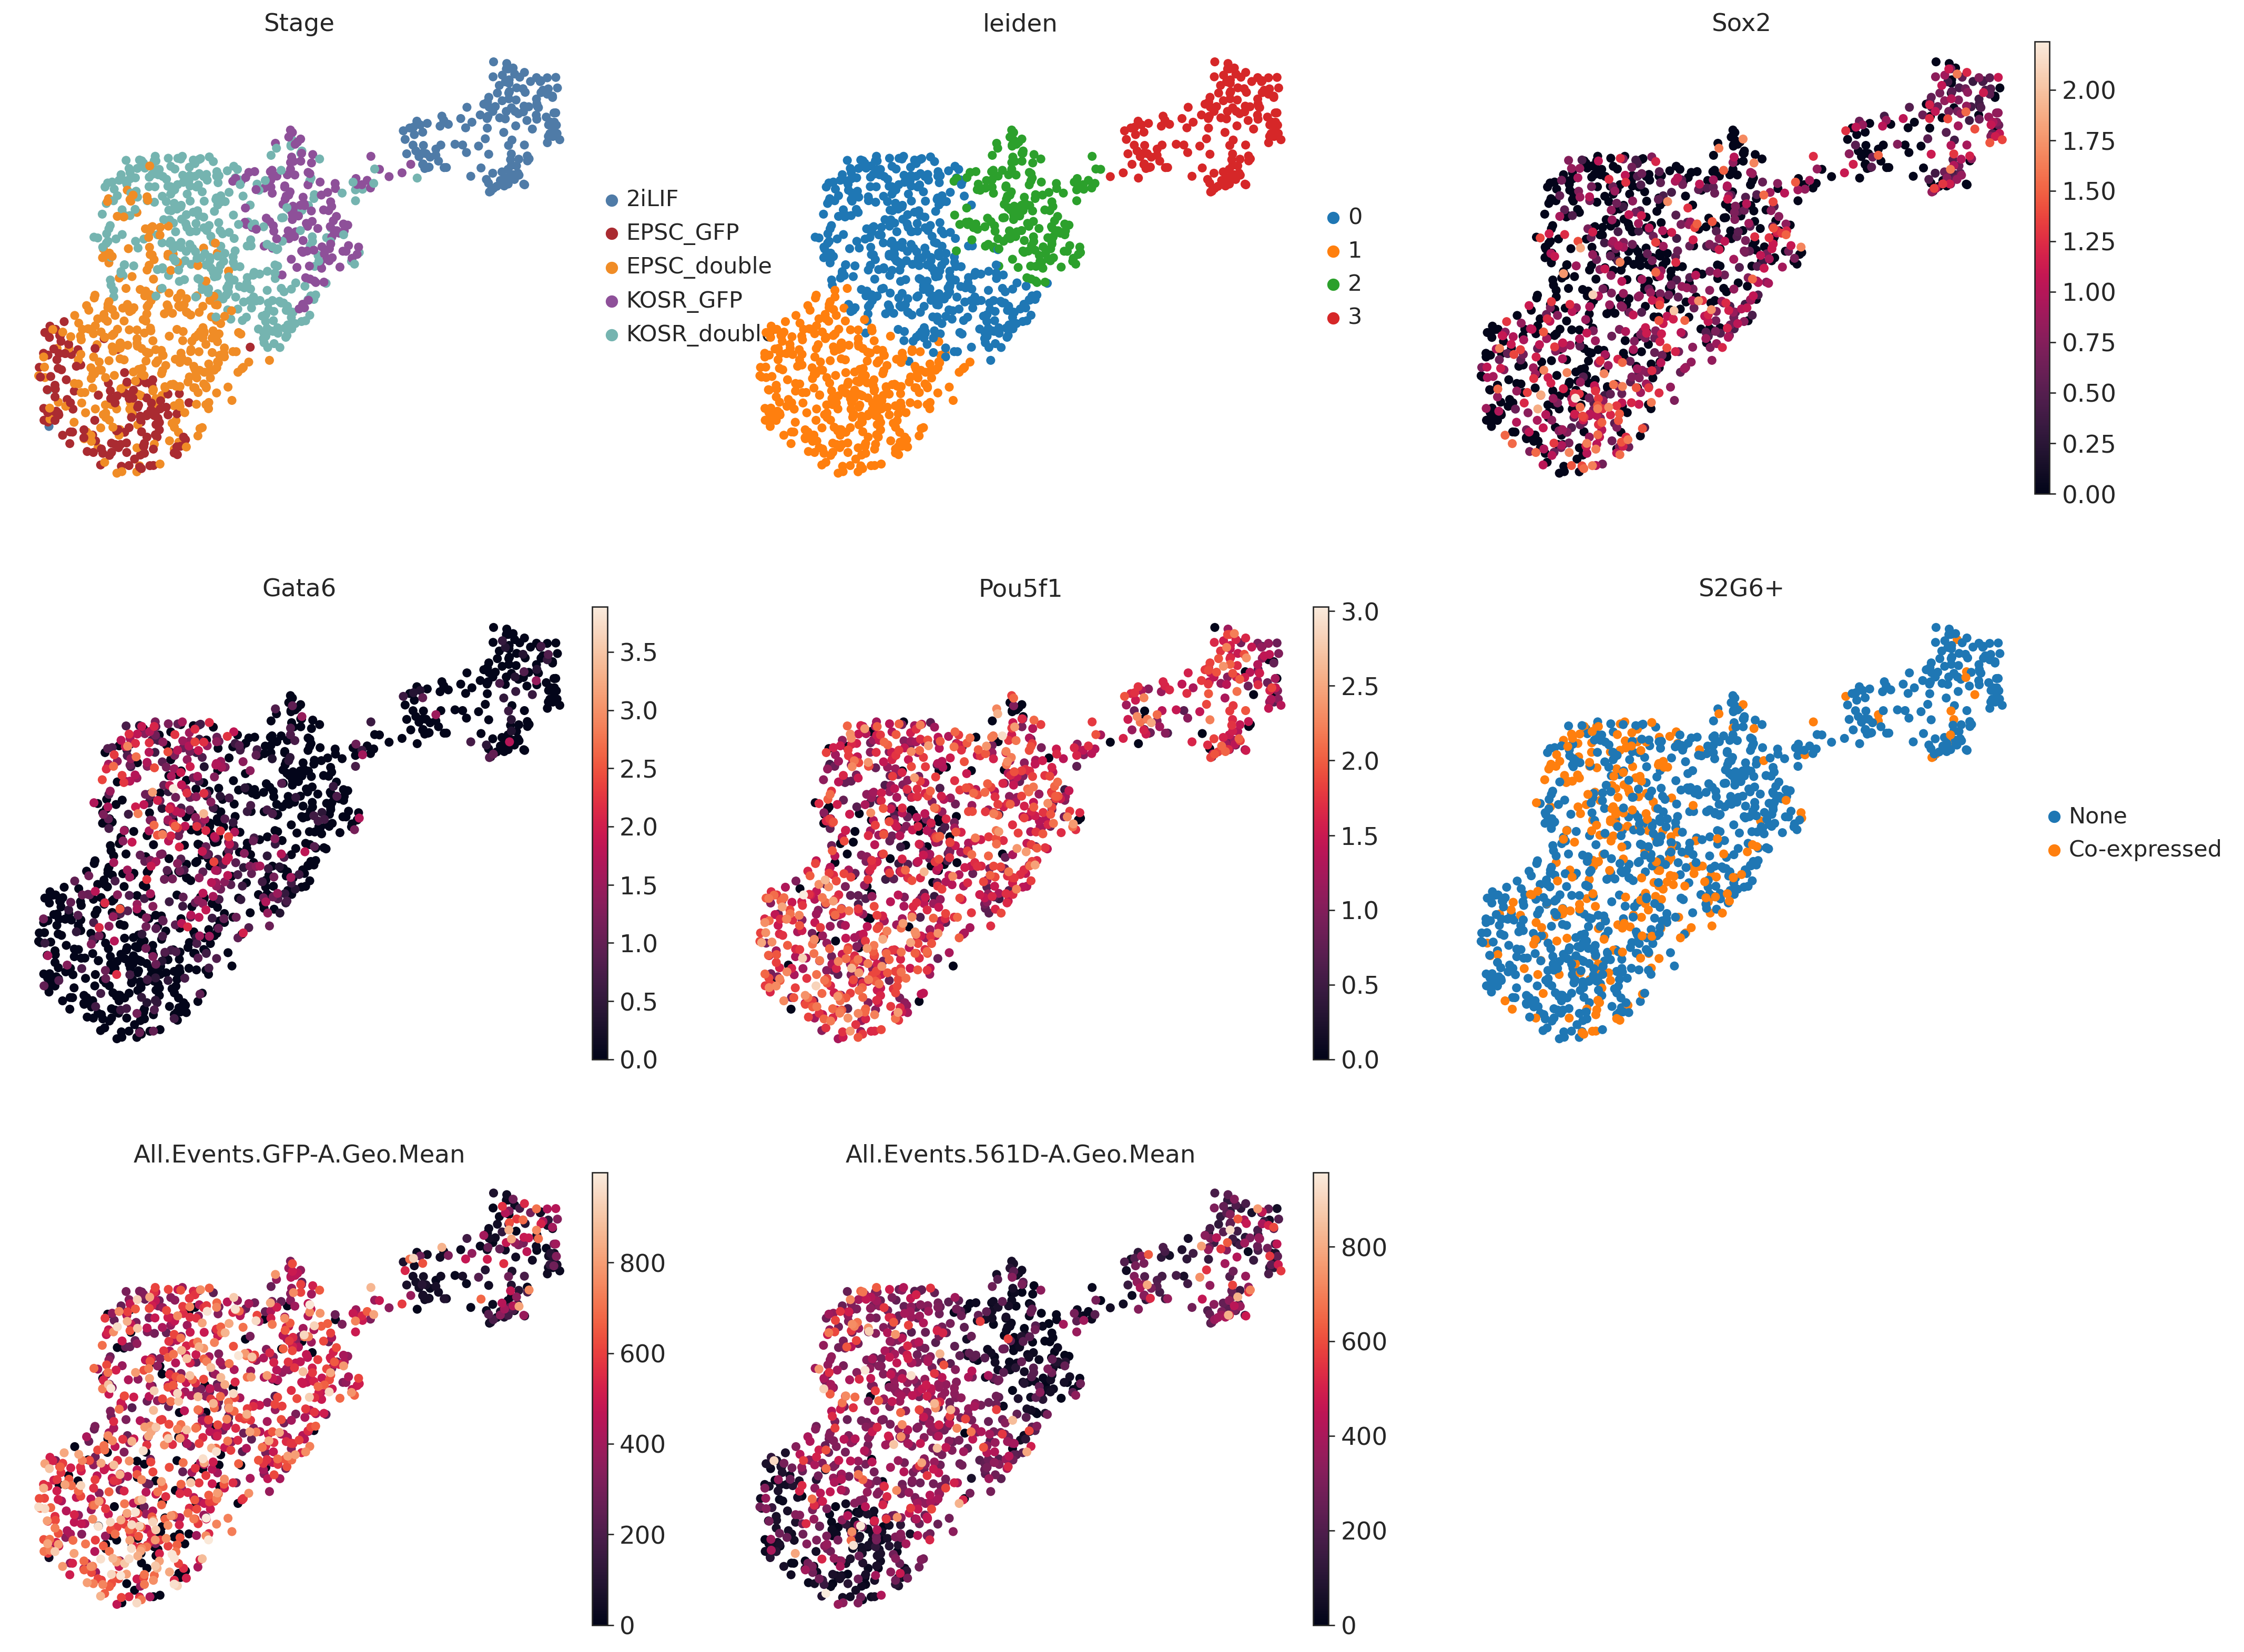

In [4]:
sc.pl.umap(adata, color=['Stage', 'leiden', 'Sox2', 'Gata6', 'Pou5f1', 'S2G6+',
                         'All.Events.GFP-A.Geo.Mean', 'All.Events.561D-A.Geo.Mean'], ncols=3, frameon=False, save='_extra.svg')

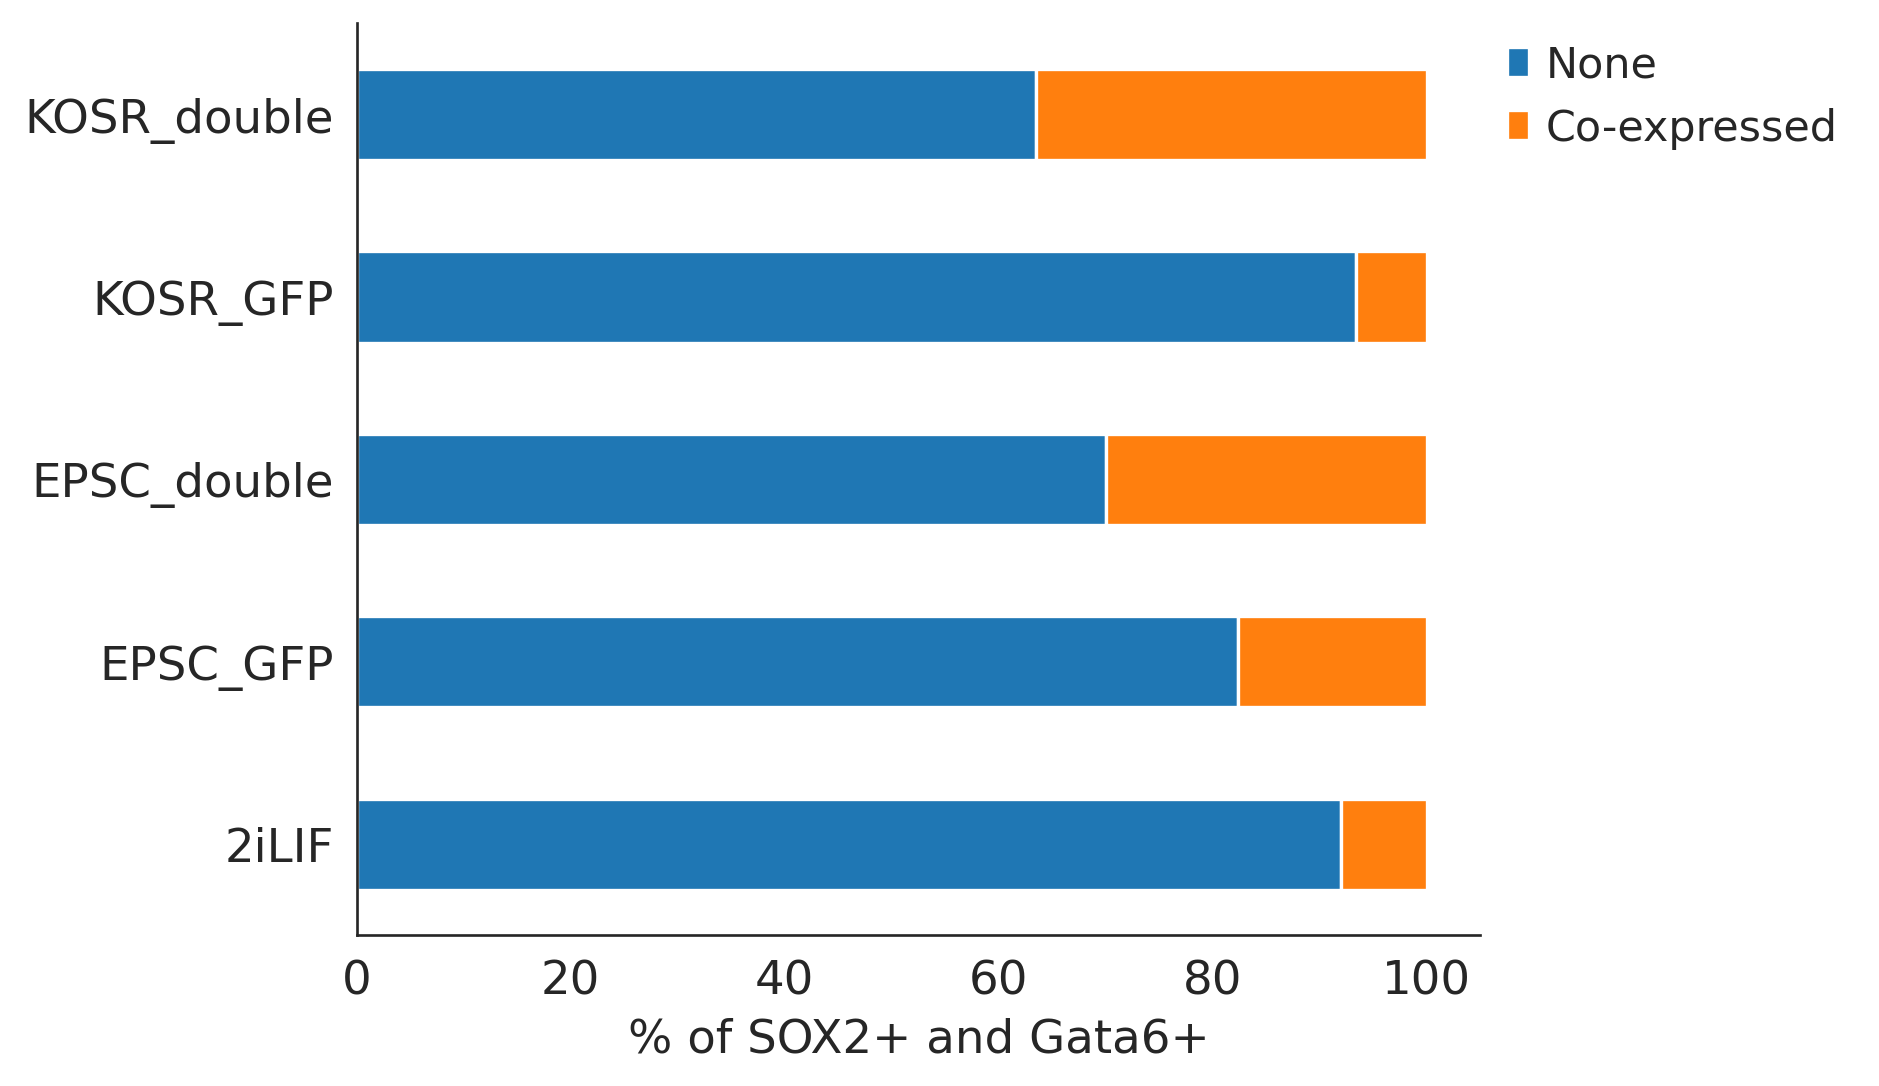

In [5]:
df = adata.obs.groupby(['Stage', 'S2G6+']).apply(len).unstack()
df /= df.sum(axis=1).values[:, np.newaxis]
df *= 100

df.plot(kind='barh', stacked=True)
plt.gca().legend(bbox_to_anchor=(0.99, 1.02), loc='upper left', frameon=False)
plt.gca().spines[['right', 'top']].set_visible(False)
_ = plt.xlabel('% of SOX2+ and Gata6+')
_ = plt.ylabel('')

## Fig. 1

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


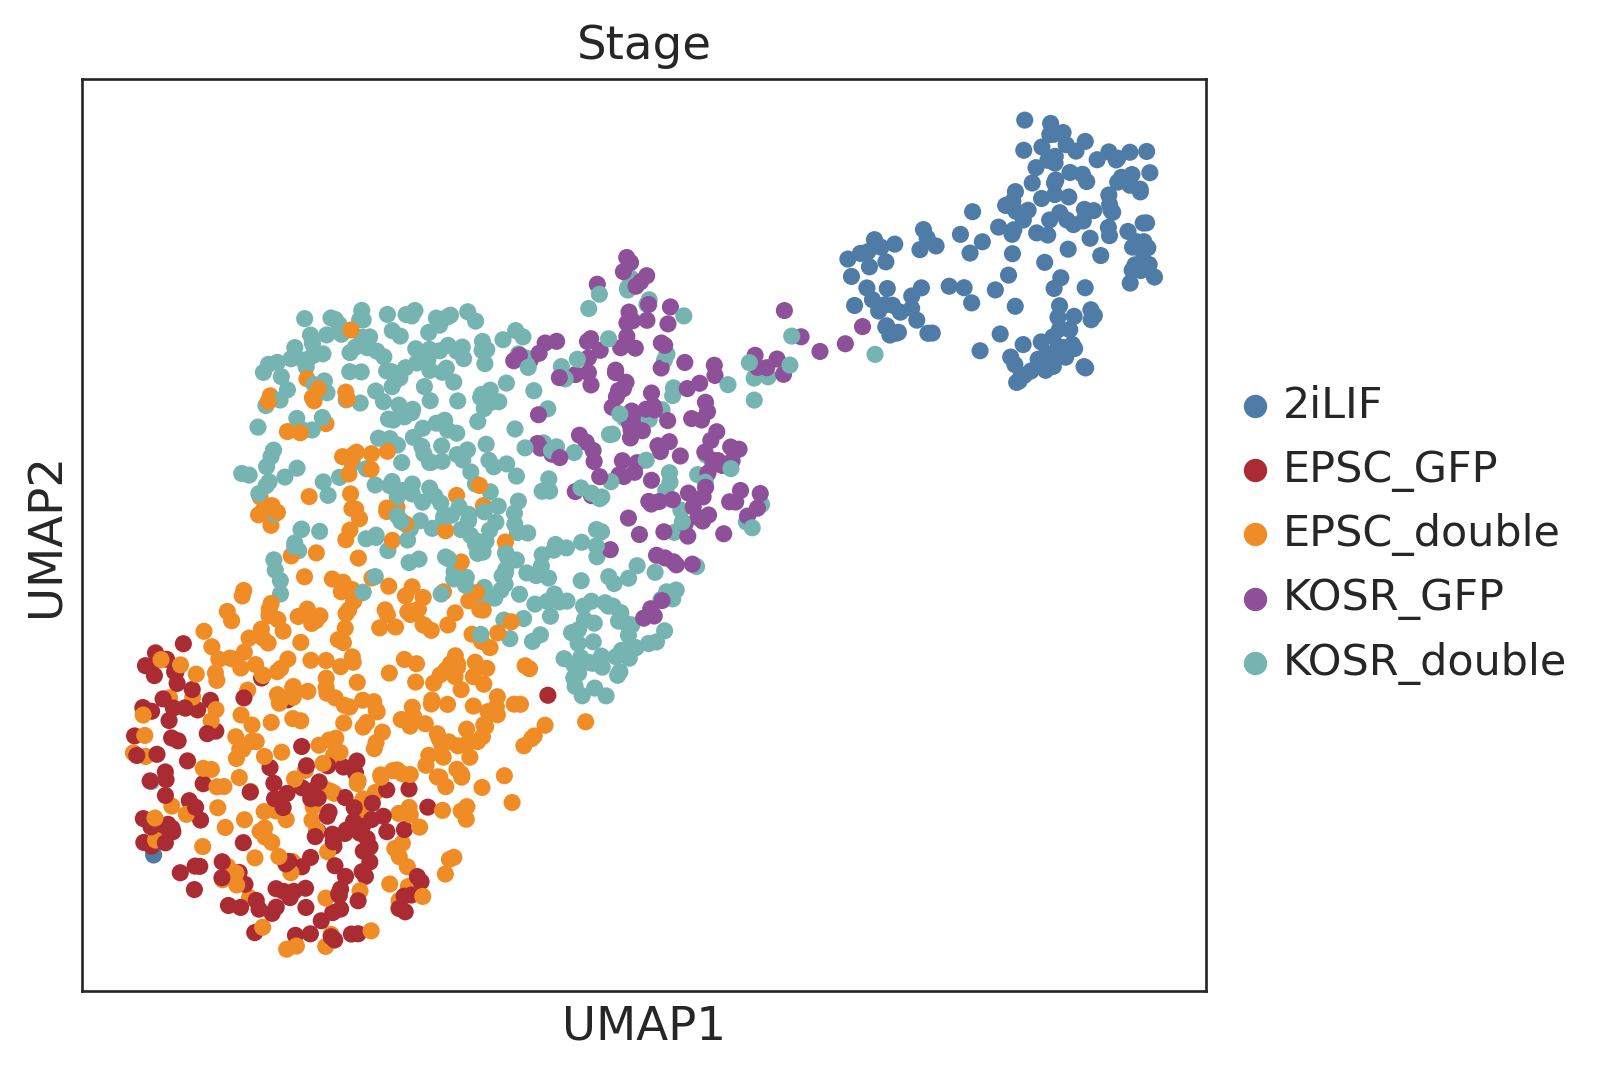

In [6]:
sc.pl.umap(adata, color='Stage', save='_fig-1.svg')

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


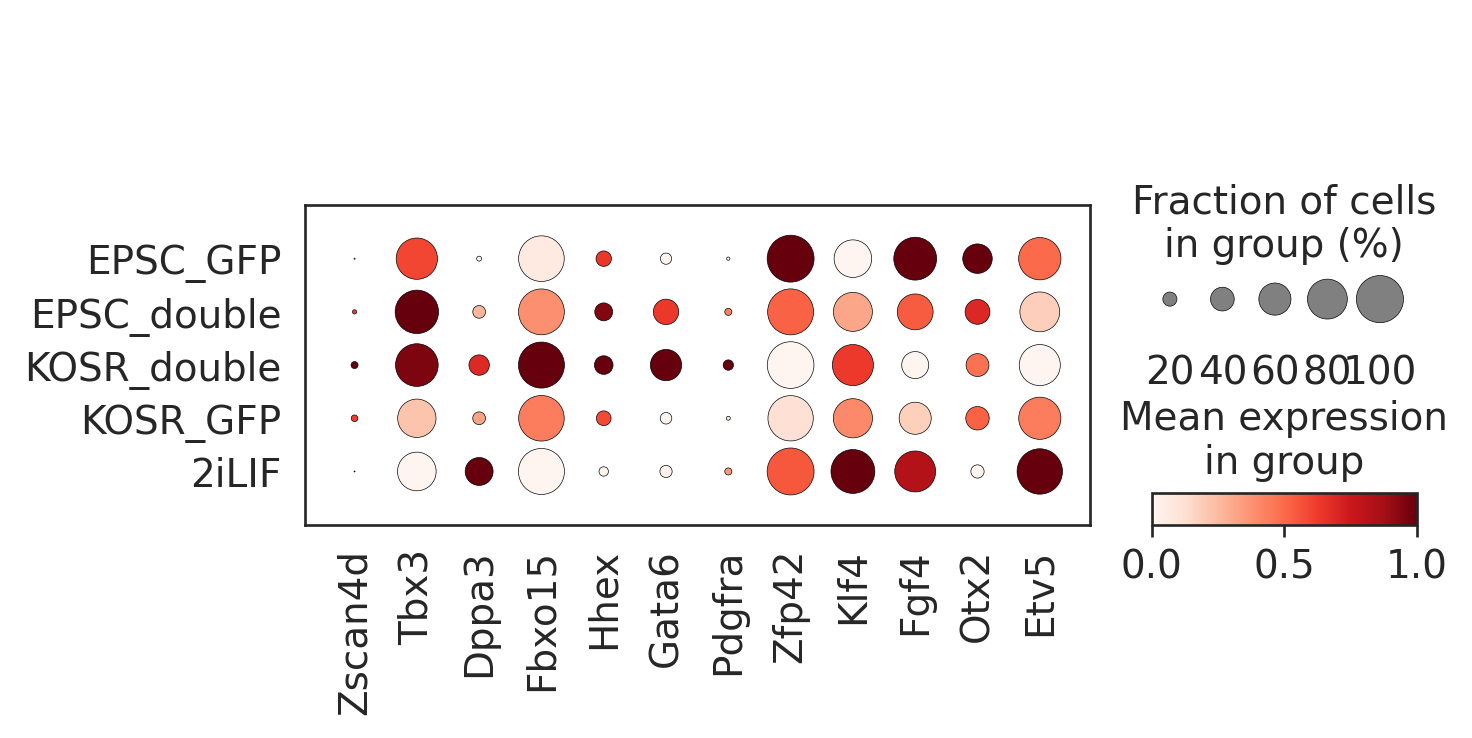

In [7]:
sc.pl.dotplot(adata,
              ['Zscan4d', 'Tbx3', 'Dppa3', 'Fbxo15', 'Hhex', 'Gata6', 'Pdgfra', 'Zfp42', 'Klf4', 'Fgf4', 'Otx2', 'Etv5'], 
              categories_order=['EPSC_GFP', 'EPSC_double', 'KOSR_double', 'KOSR_GFP', '2iLIF'],
              groupby='Stage', standard_scale='var', save='fig-1.svg')

In [8]:
from typing import Dict, Optional, Tuple


def plt_violin_sig(
    adata,
    groupby: str,
    gene: str,
    pairs: list[Tuple[str, str]],
    order: Optional[list[str]] = None,
    colors: Optional[Dict[str, str]] = None,
    save: Optional[str] = None
):
    from scipy.stats import mannwhitneyu
    from statannotations.Annotator import Annotator

    def format_pval(pval, use_asterisk=True) -> str:
        if use_asterisk is False:
            return f"{pval:.2e}"

        if pval < 0.001:
            return "***"
        if pval < 0.01:
            return "**"
        if pval < 0.05:
            return "*"

        return "ns"

    groups = adata.obs.groupby(groupby).groups
    columns = groups.keys()
    df = pd.DataFrame(
        [adata.raw[x, gene].X.toarray().ravel() for x in groups.values()], index=columns
    ).T

    pvals = [
        mannwhitneyu(df[a], df[b], alternative="two-sided", nan_policy="omit").pvalue
        for a, b in pairs
    ]
    formatted_pvalues = list(map(format_pval, pvals))

    params = {"data": df.melt(), "x": "variable", "y": "value", "order": order}
    params_kwd = {"cut": 0, "inner": None}

    with sns.plotting_context("notebook", font_scale=1):
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))

        ax = sns.violinplot(**params, palette=colors, **params_kwd)
        sns.stripplot(**params, jitter=True, zorder=1, size=1, palette="dark:black")

        annotator = Annotator(
            ax, pairs, **params, palette=colors, **params_kwd, verbose=False
        )
        annotator.set_custom_annotations(formatted_pvalues)
        annotator.annotate()

        plt.gca().spines[["right", "top"]].set_visible(False)
        _ = plt.ylabel("Gene expression [AU]")
        _ = plt.xlabel("")
        plt.title(gene, loc="left")
        
        if save is not None:
            plt.savefig(save)
        
        plt.show()

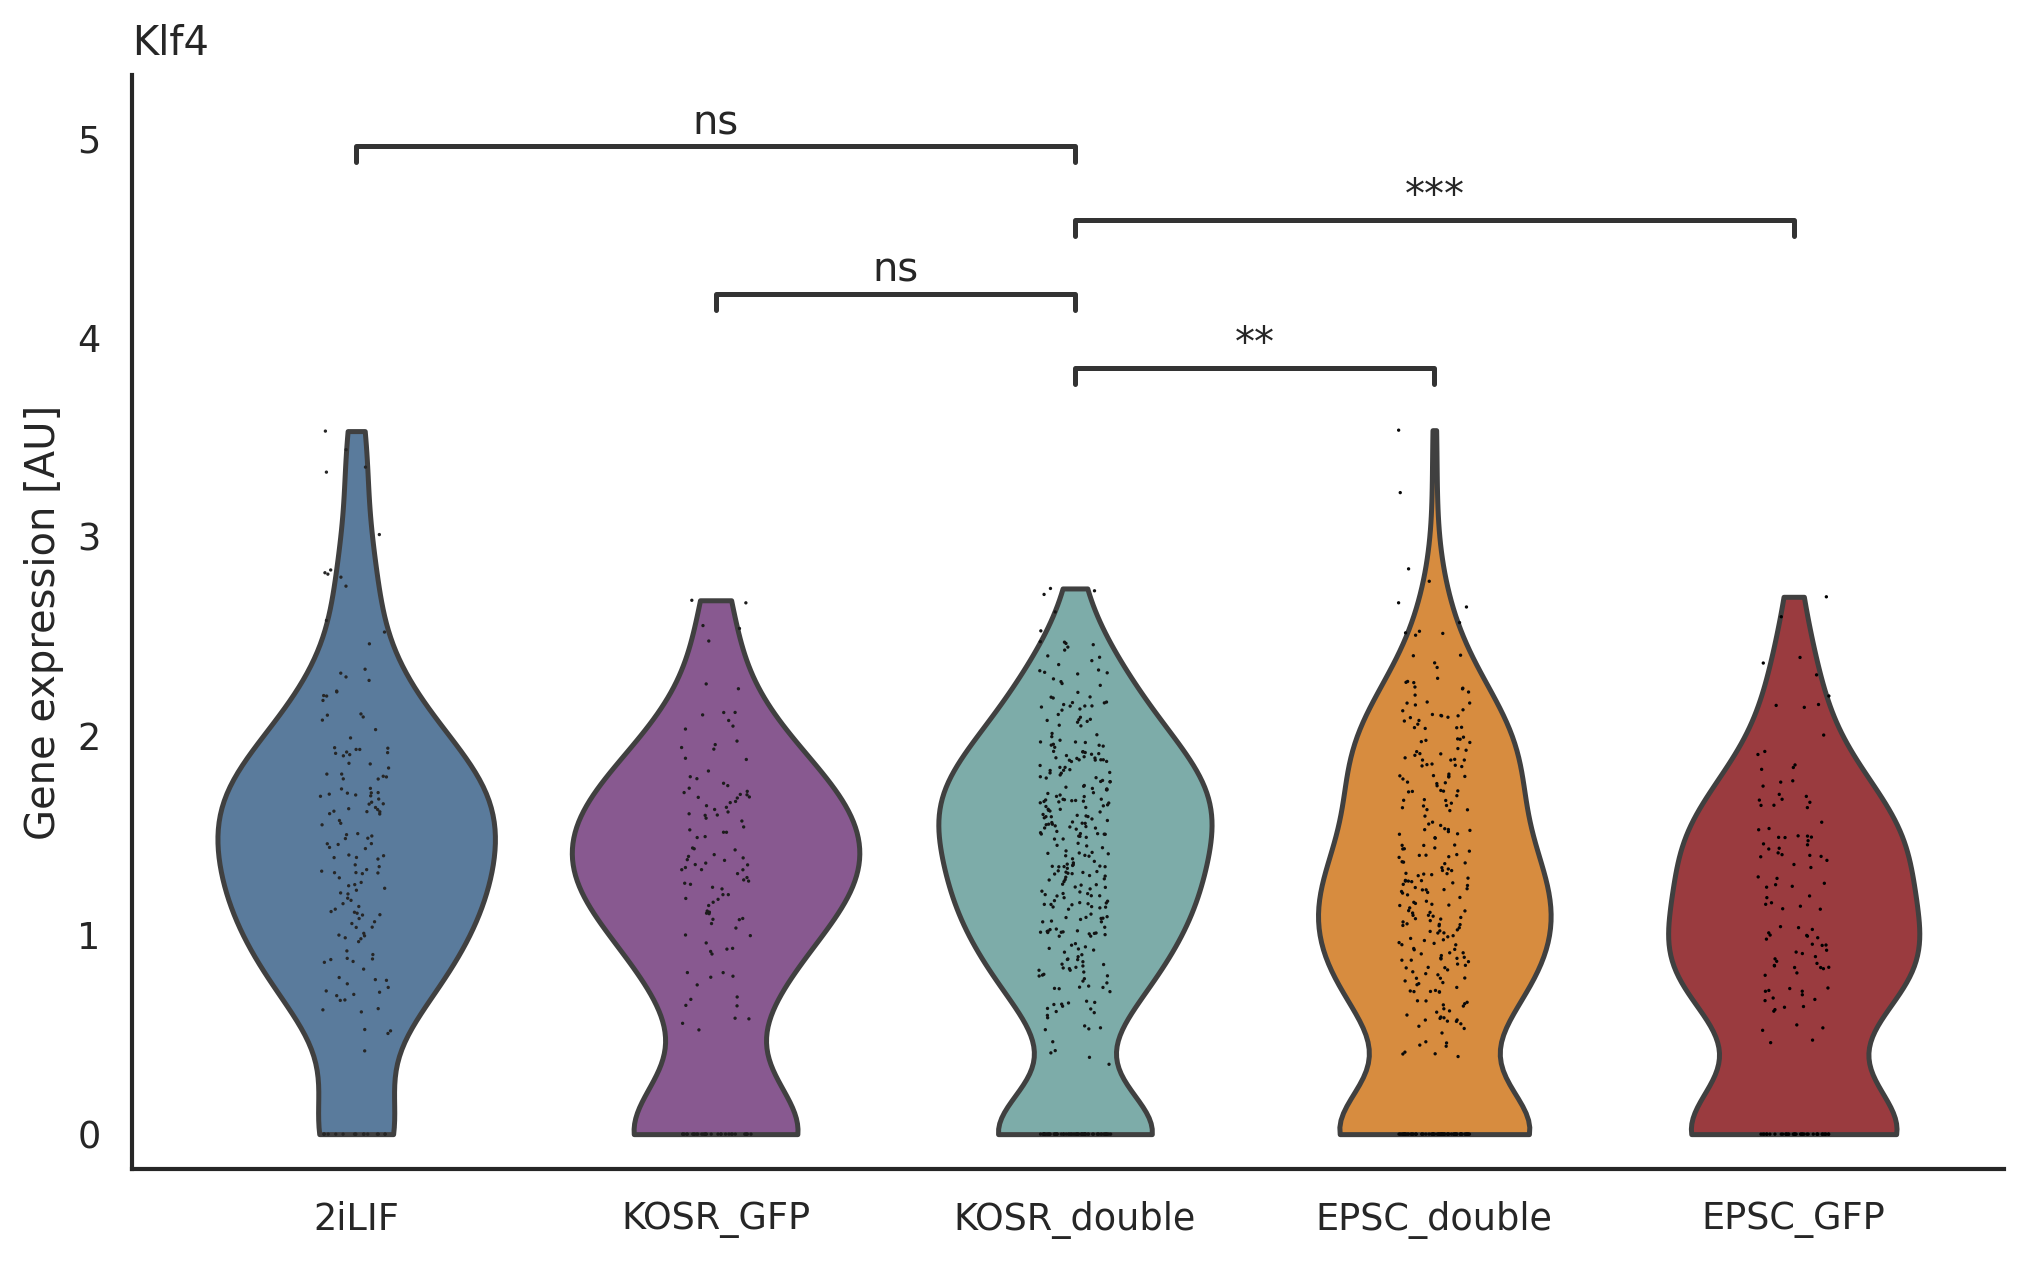

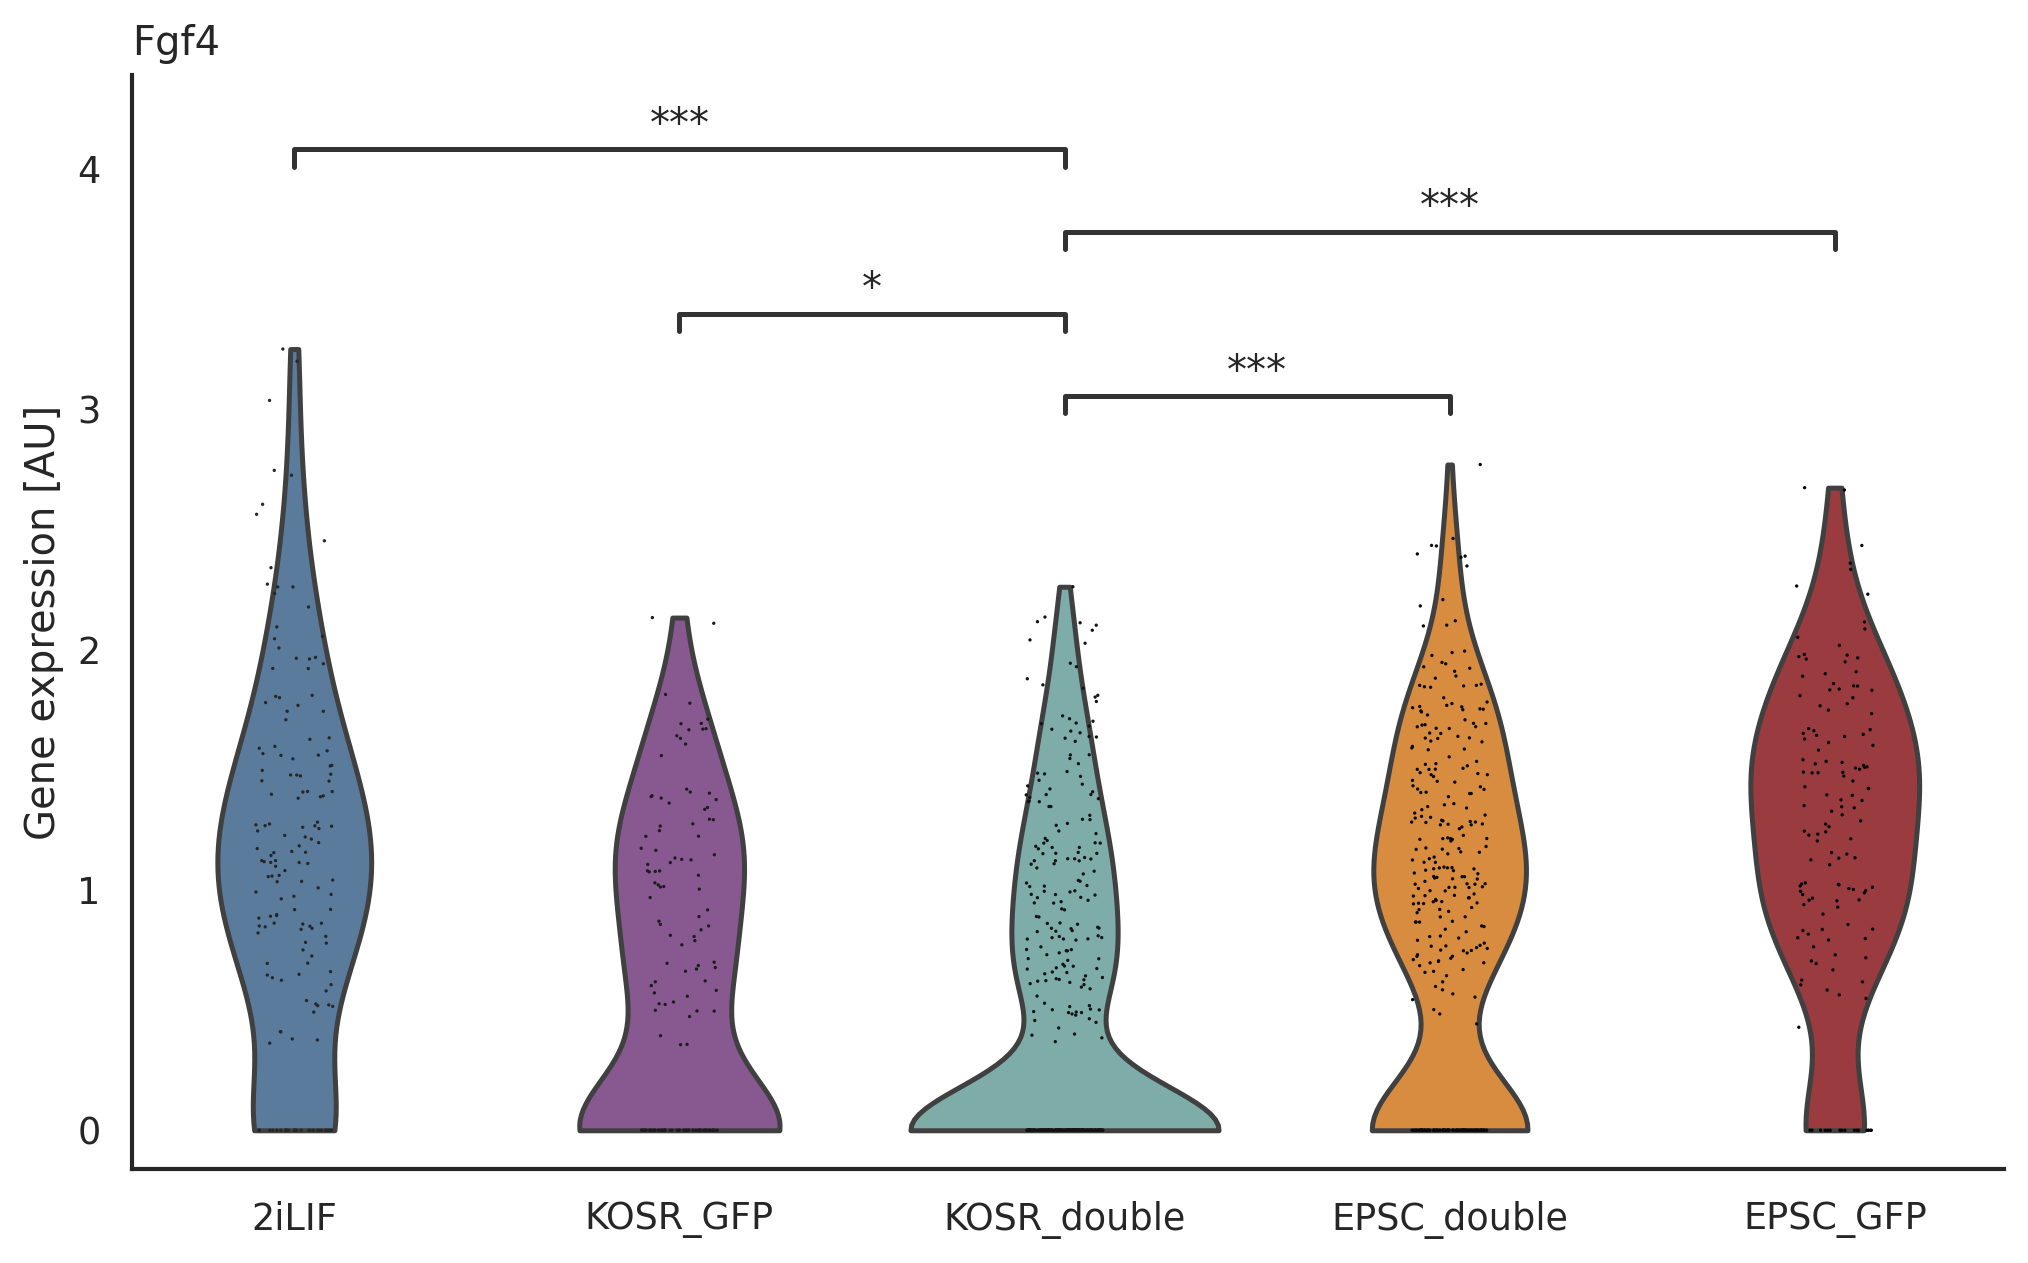

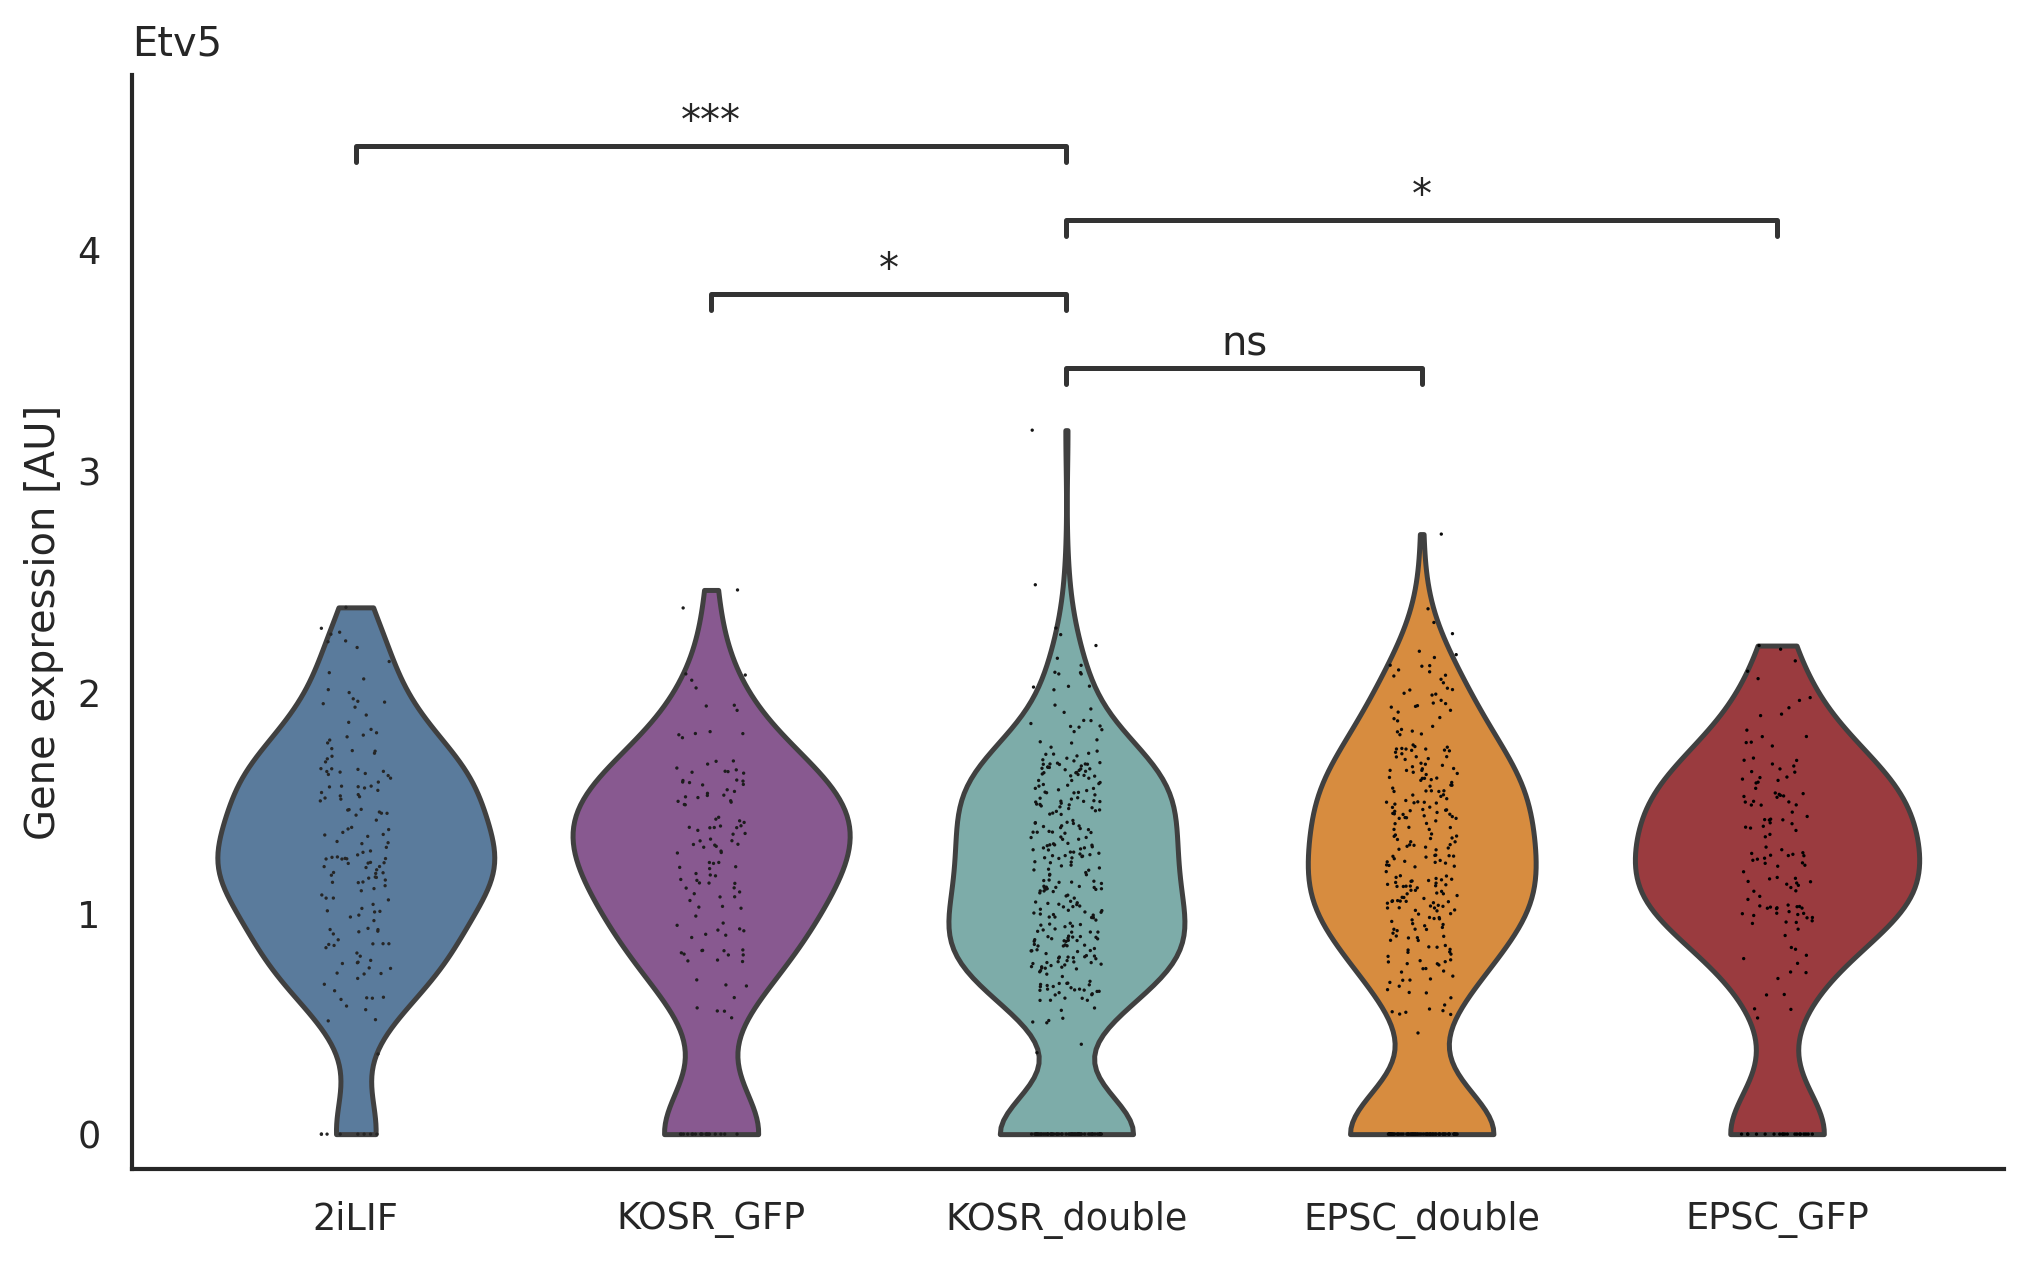

In [9]:
pairs = [
    ('KOSR_double', 'EPSC_GFP'),
    ('2iLIF', 'KOSR_double'),
    ('KOSR_double', 'EPSC_double'),
    ('KOSR_GFP', 'KOSR_double')
]
order = ['2iLIF', 'KOSR_GFP', 'KOSR_double', 'EPSC_double', 'EPSC_GFP']
colors = dict(zip(adata.obs.Stage.cat.categories, adata.uns['Stage_colors']))
genes = ['Fbxo15', 'Dppa3', 'Gata6', 'Klf4', 'Otx2', 'Fgf4', 'Etv5']

for gene in genes:
    plt_violin_sig(adata, groupby='Stage', gene=gene, pairs=pairs, order=order, colors=colors, save=f'{sc.settings.figdir}/{gene}-fig-1.svg')

## Supl. 2

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


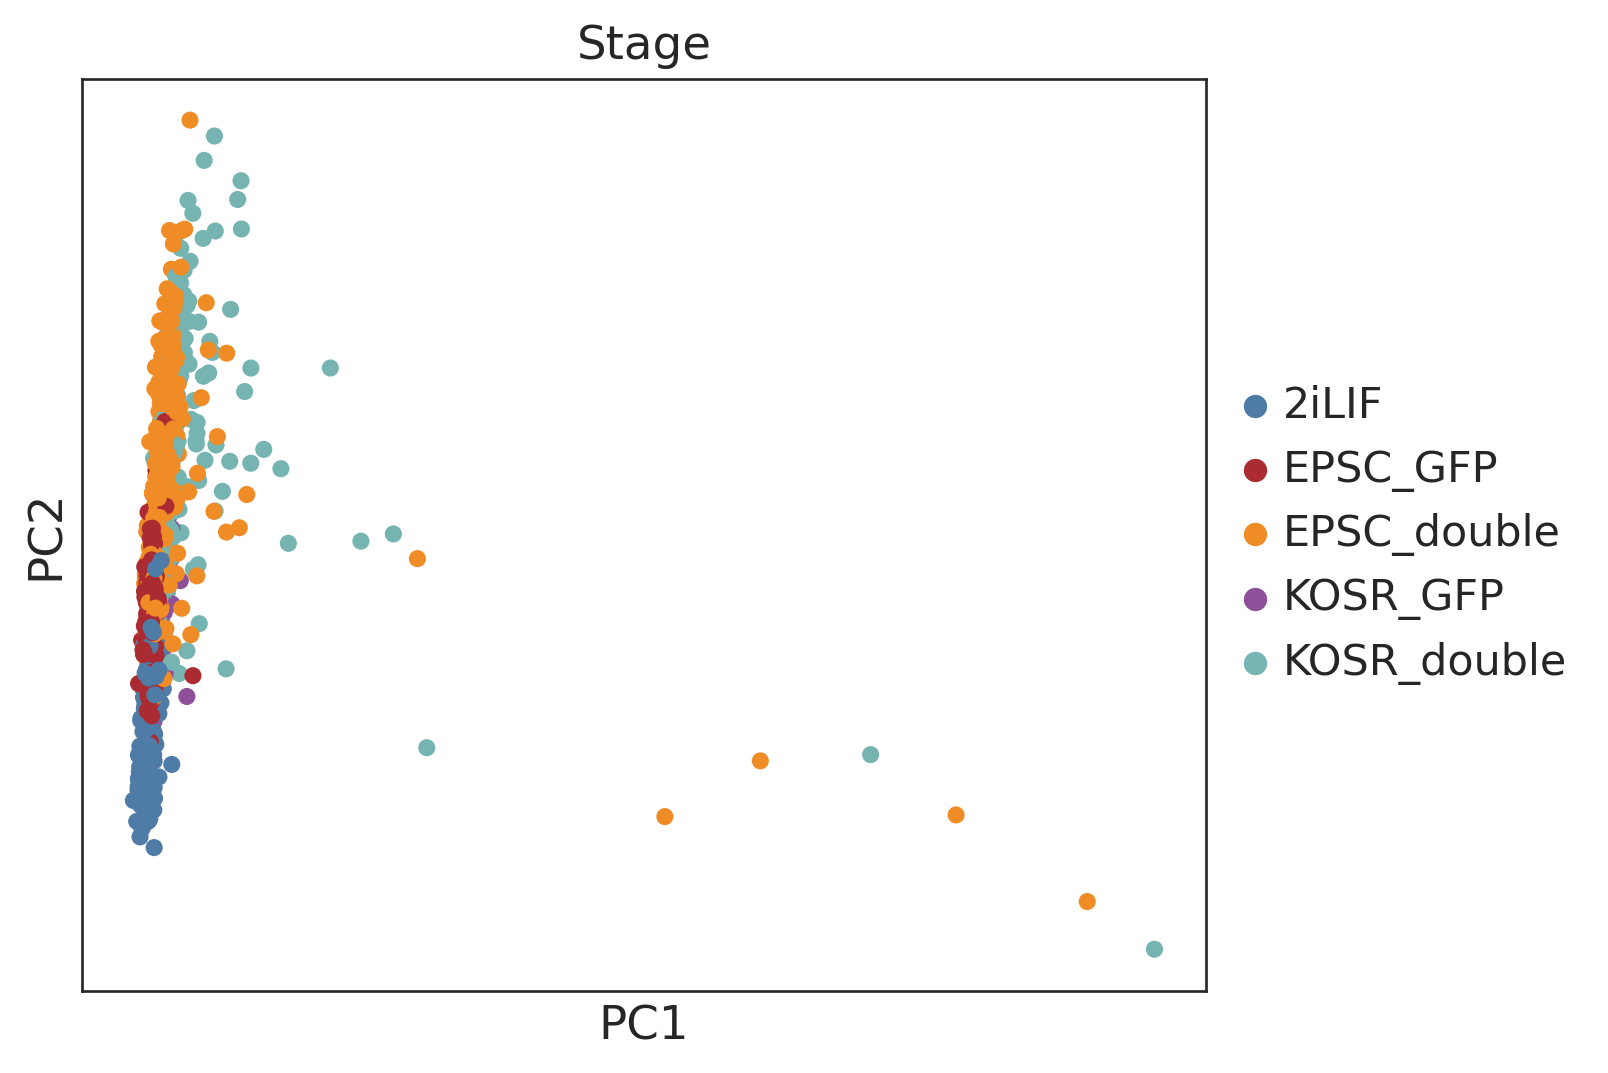

In [10]:
sc.pl.pca(adata, color='Stage', save='_supl-2.svg')

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


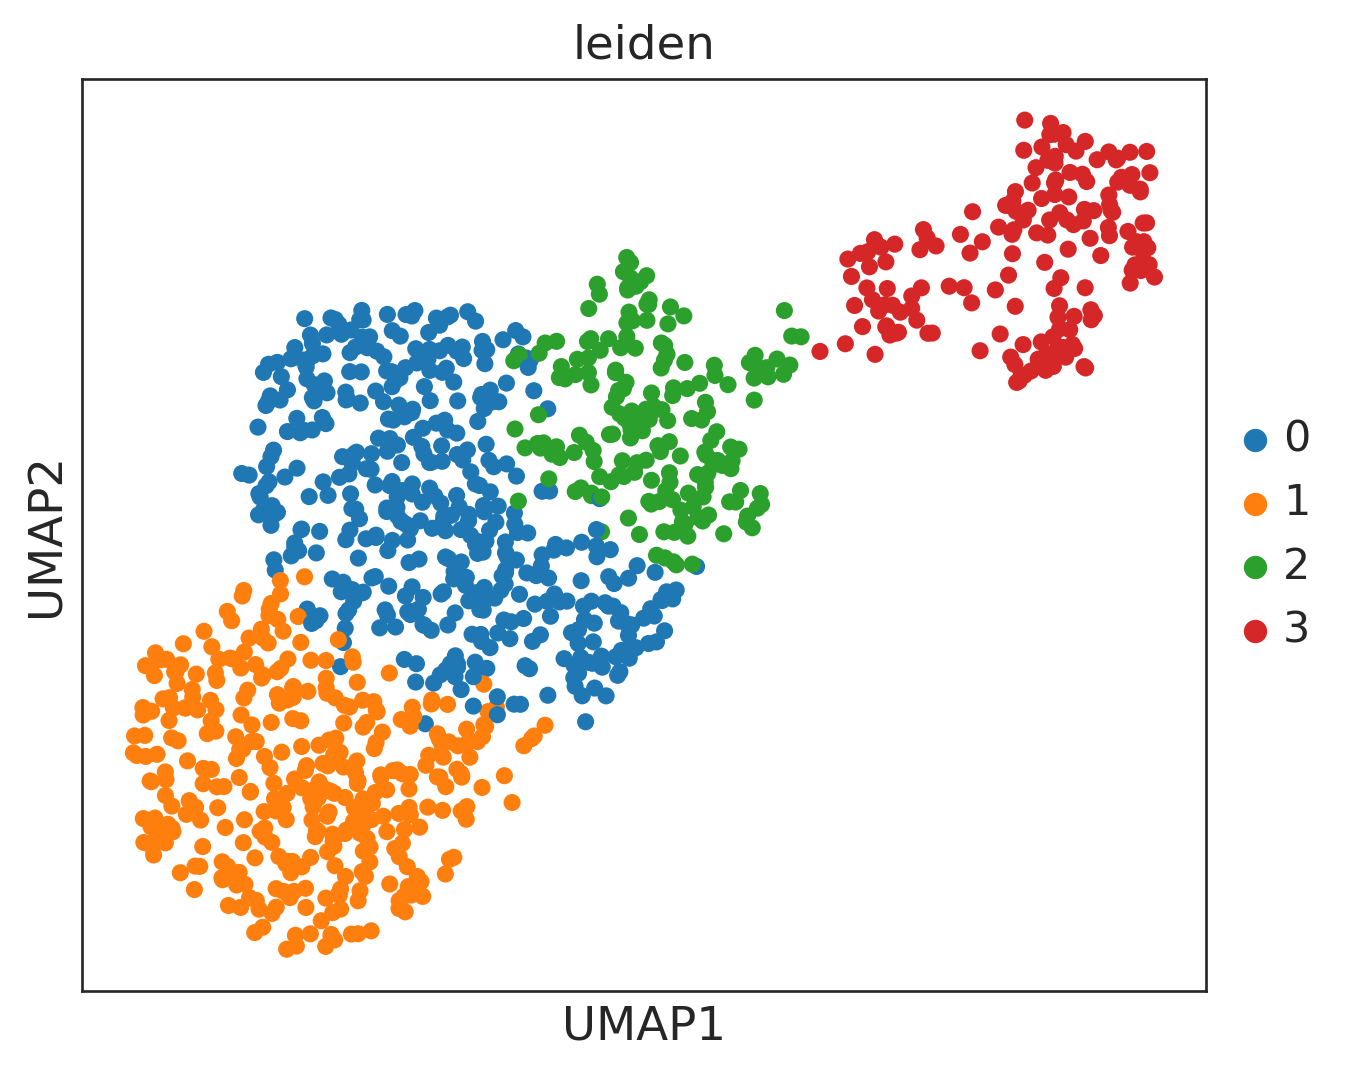

In [11]:
sc.pl.umap(adata, color='leiden', save='_supl-2-leiden.svg')

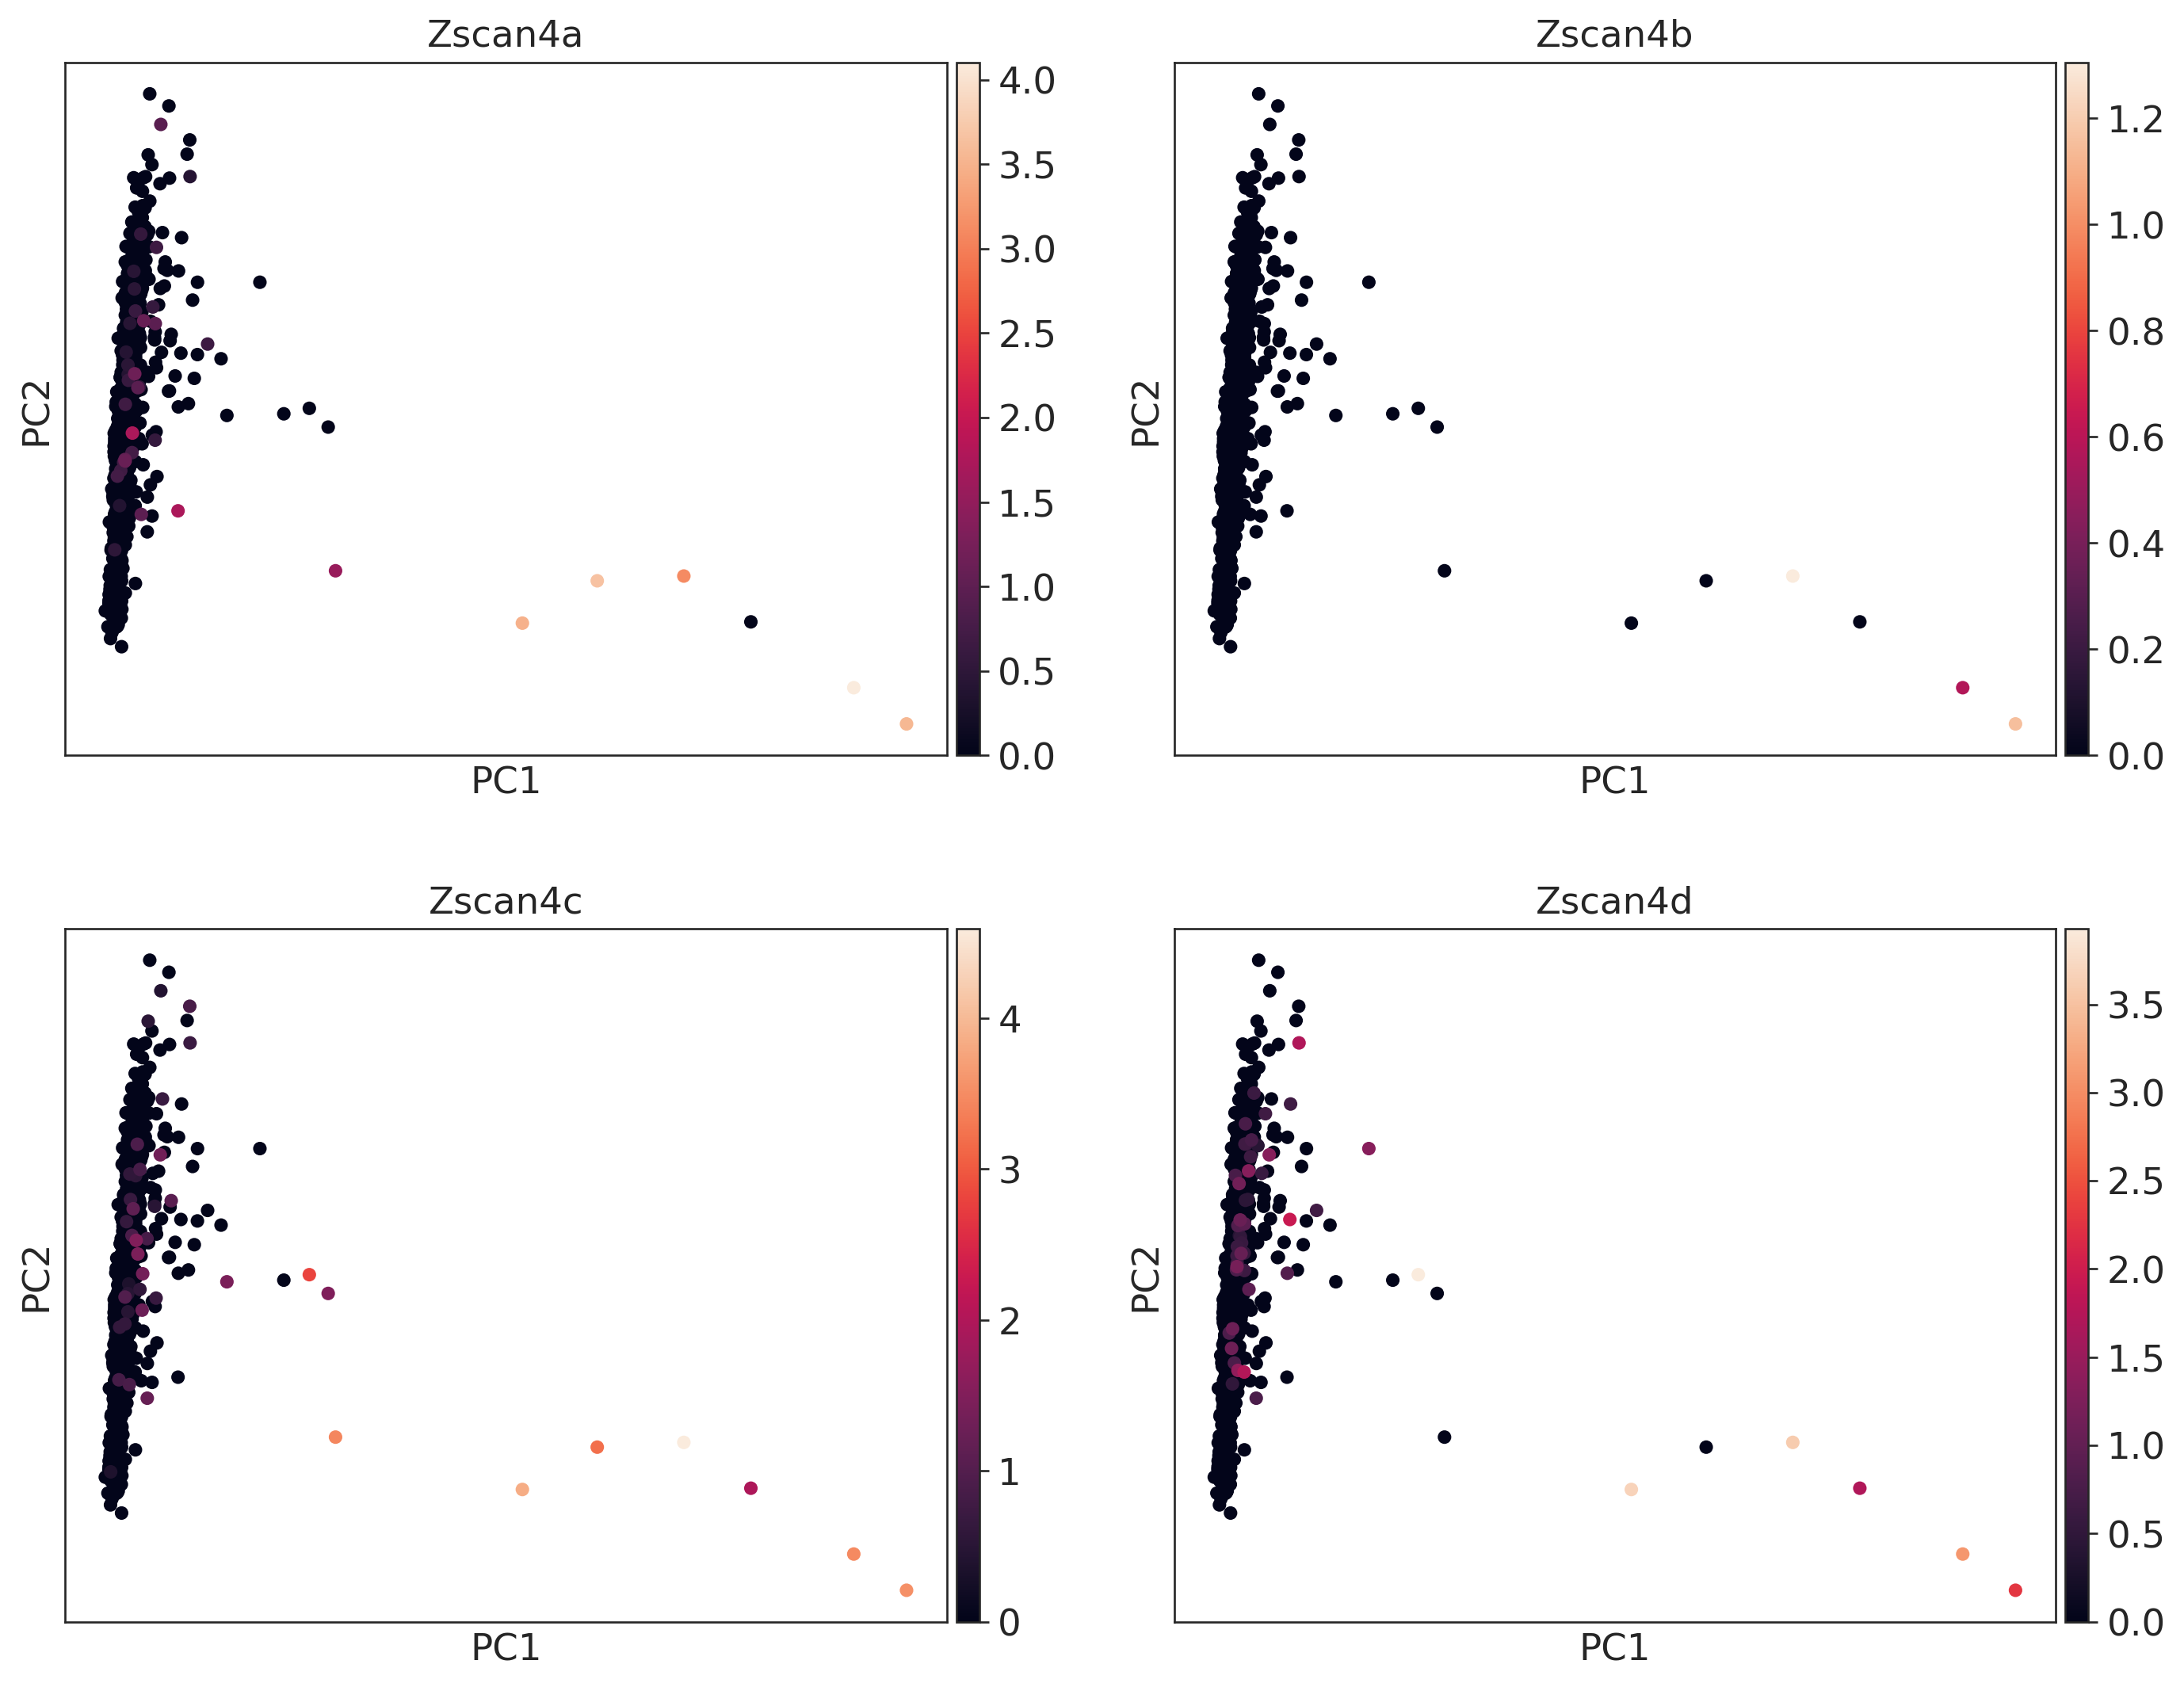

In [12]:
sc.pl.pca(adata, color=['Zscan4a', 'Zscan4b', 'Zscan4c', 'Zscan4d'], ncols=2, save='_supl-2-zscans.svg')

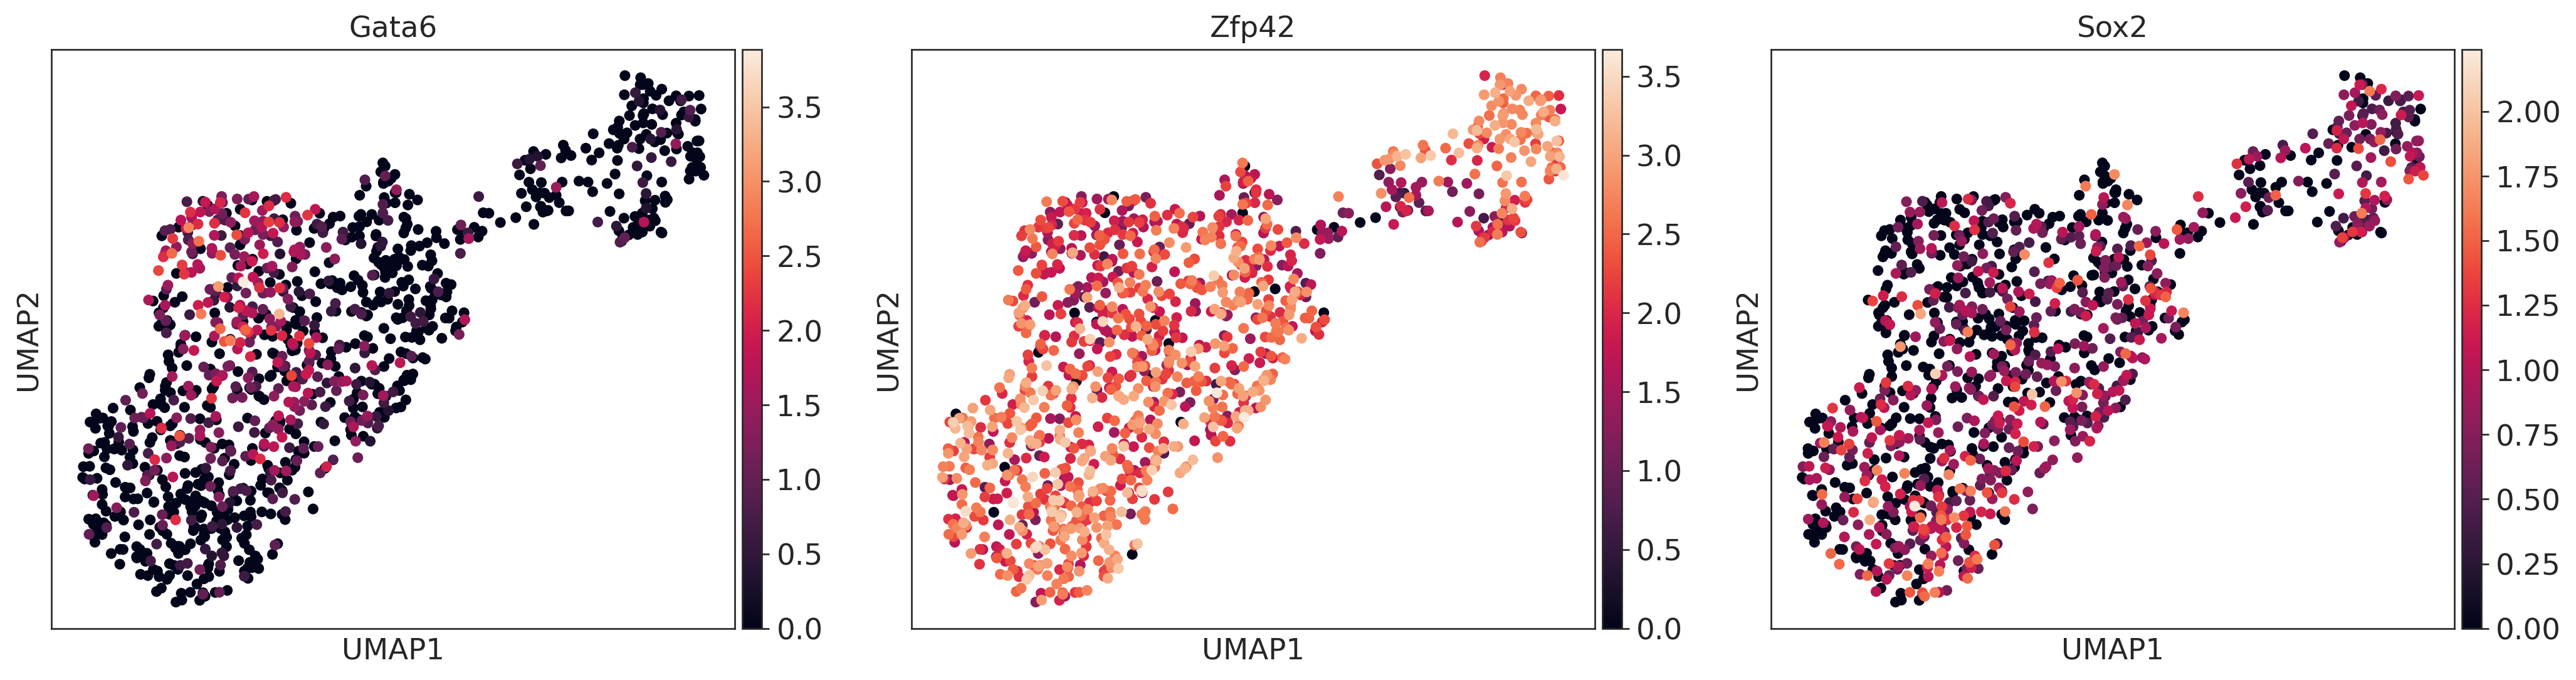

In [13]:
sc.pl.umap(adata, color=['Gata6', 'Zfp42', 'Sox2'], ncols=3, save='_supl-2-markers.svg')

## Supl. 3

In [4]:
oxphos = pd.read_table("https://www.informatics.jax.org/go/report.txt?goID=GO:0006119&results=229&startIndex=0&sort=term&dir=")['MGI Gene/Marker ID'].unique()
glycolisis = pd.read_table("https://www.informatics.jax.org/go/report.txt?goID=GO:0006096&results=192&startIndex=0&sort=term&dir=")['MGI Gene/Marker ID'].unique()

In [5]:
avg_expr = pd.DataFrame(columns=adata.var_names, index=adata.obs['Stage'].cat.categories)                                                                                                 

for clust in adata.obs.Stage.cat.categories: 
    avg_expr.loc[clust] = adata[adata.obs['Stage'].isin([clust]),:].X.mean(0)

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


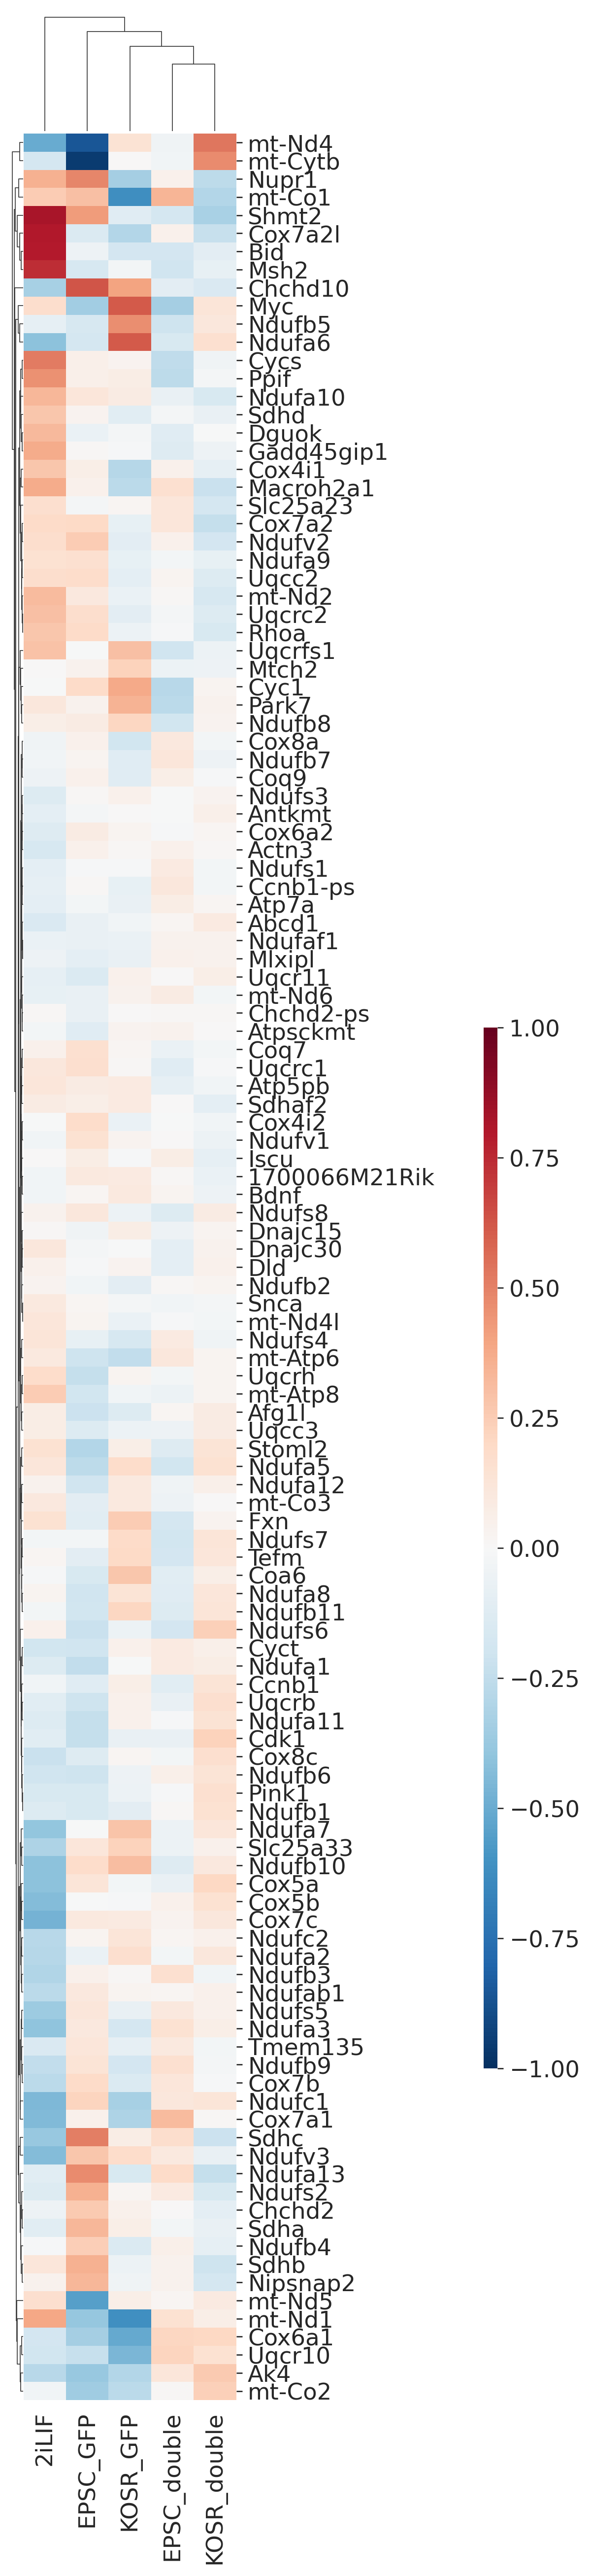

In [6]:
g = sns.clustermap(
    avg_expr[avg_expr.columns.intersection(oxphos)].T.astype(np.float32),
    cmap='RdBu_r',
    vmin=-1, vmax=1, 
    yticklabels=True,
    square=True,
    figsize=(4, 22),
    cbar_pos=(1.05, .2, .03, .4),
    dendrogram_ratio=0.05
)
# g.ax_heatmap.set_title('Oxidative Phosphorylation (GO:0006119)')
g.savefig(f'{sc.settings.figdir}/oxphos-supl-3.svg')

In [7]:
# plt.title('Glycolytic Process (GO:0006096)', pad=20)
g = sns.clustermap(
    avg_expr[avg_expr.columns.intersection(glycolisis)].T.astype(np.float32),
    cmap='RdBu_r',
    vmin=-1, vmax=1,
    yticklabels=True,
    square=True,
    figsize=(4, 20),
    cbar_pos=(1.05, .2, .03, .4),
    dendrogram_ratio=0.05
)
g.savefig(f'{sc.settings.figdir}/glycolytic-supl-3.svg')

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


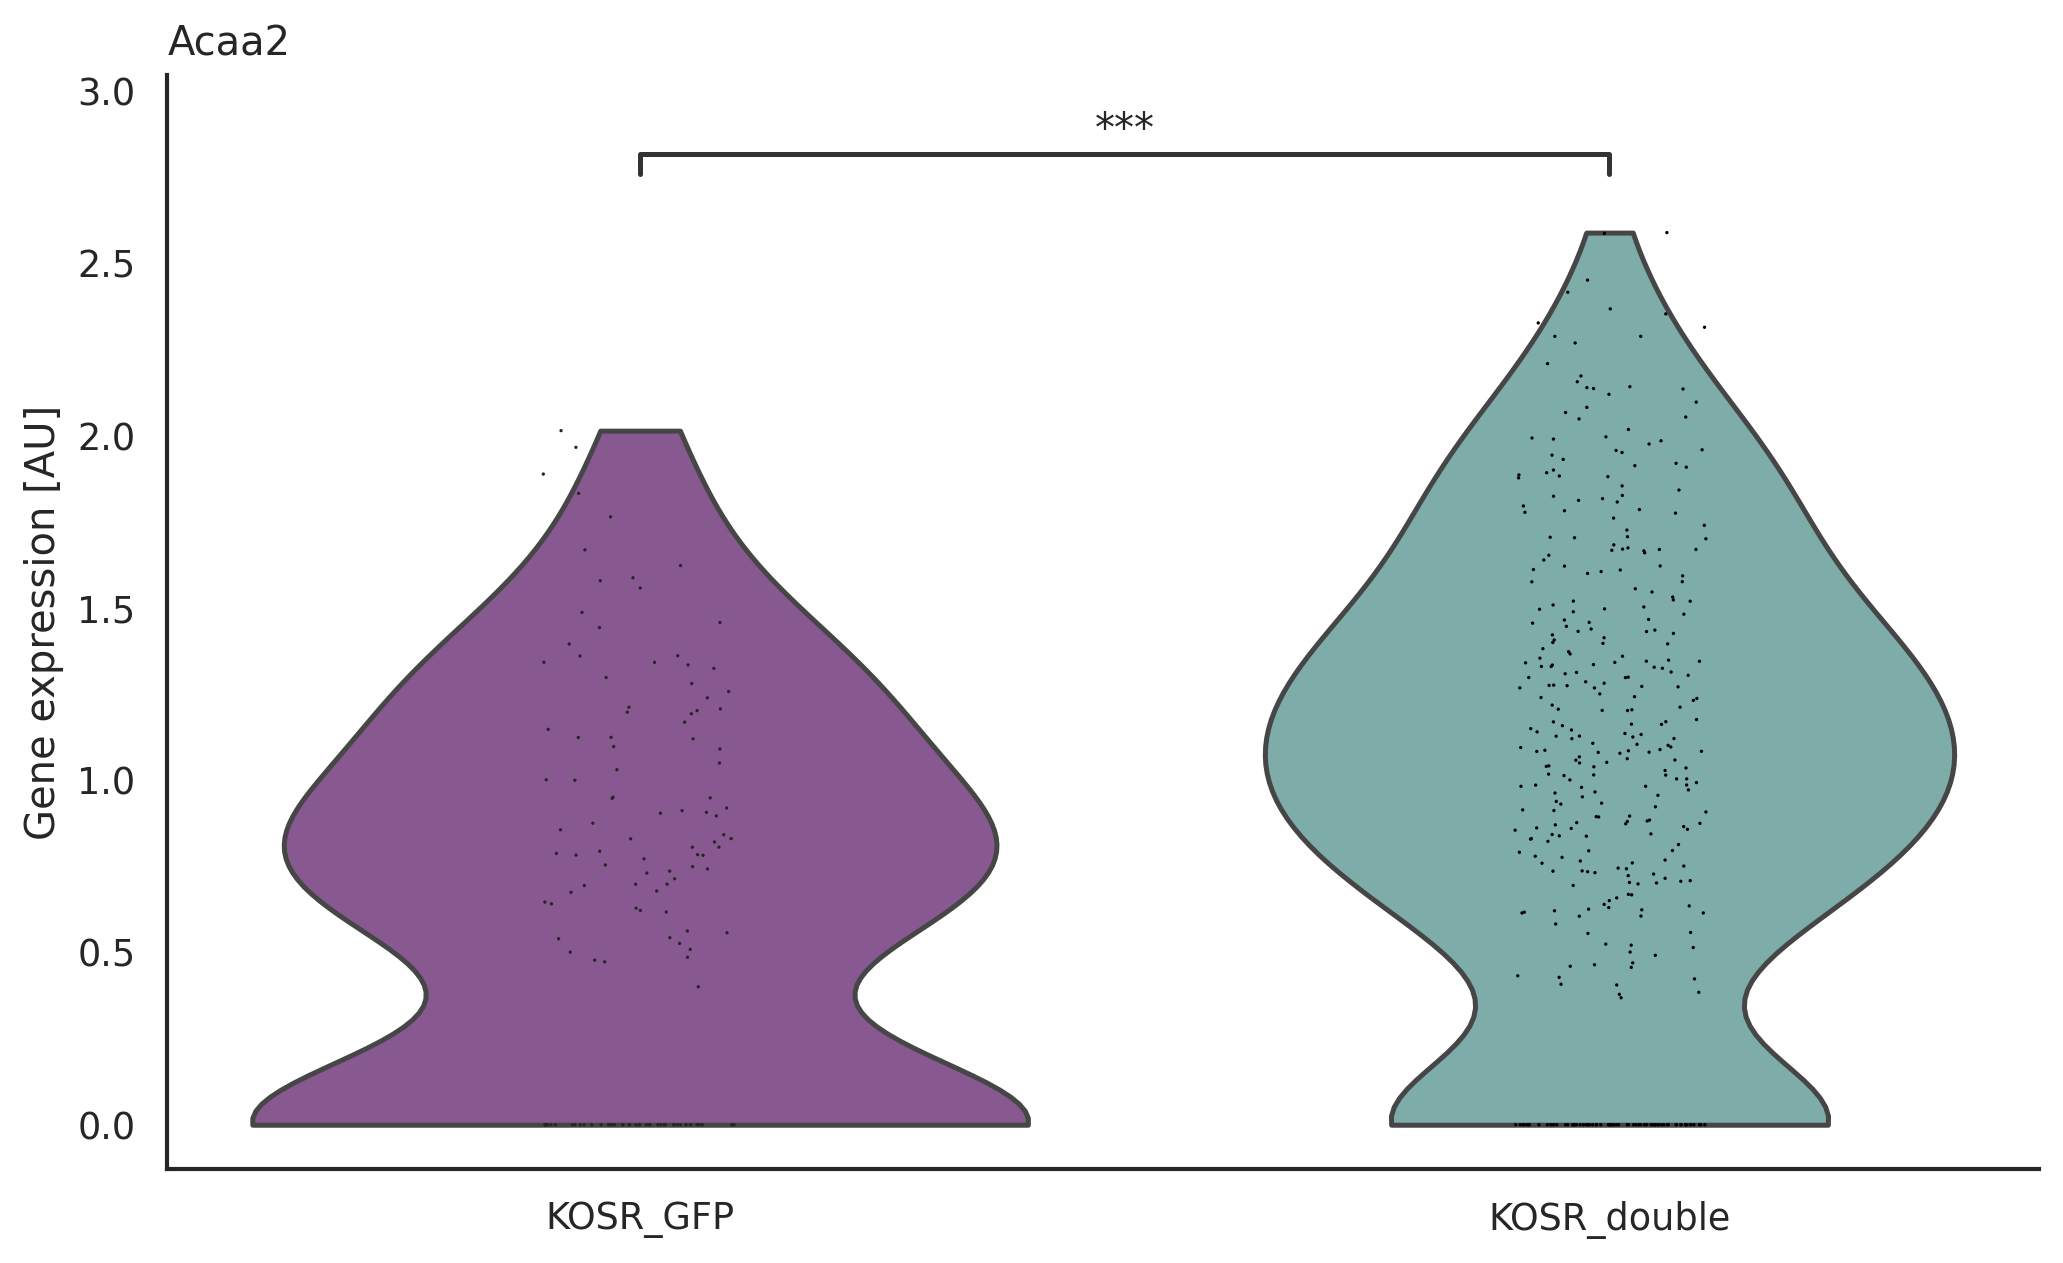

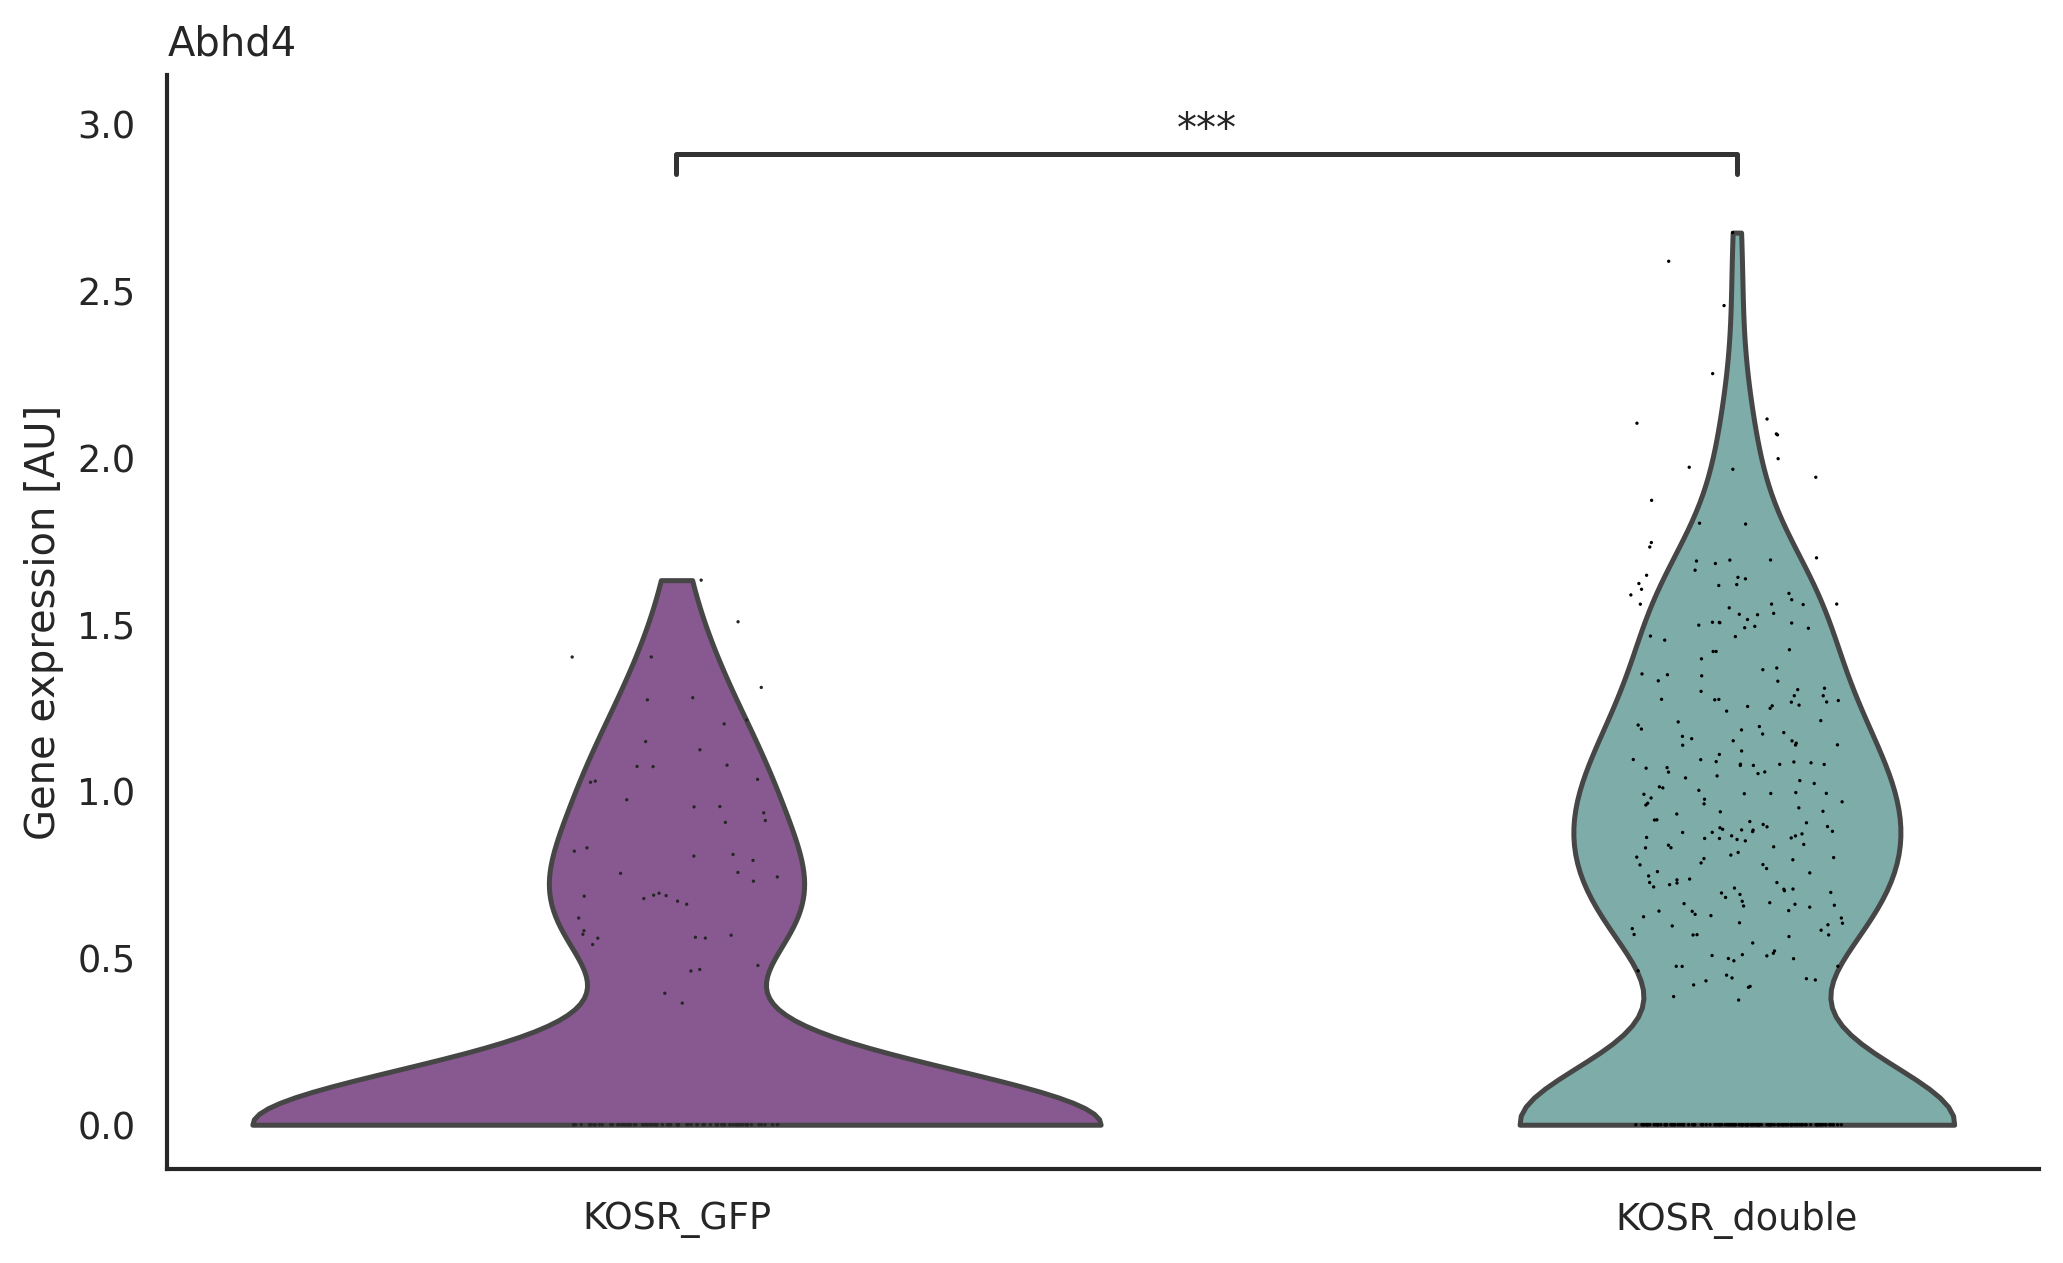

In [18]:
# Violin plots
pairs = [ ('KOSR_GFP', 'KOSR_double') ]
order = ['KOSR_GFP', 'KOSR_double']
colors = dict(zip(adata.obs.Stage.cat.categories, adata.uns['Stage_colors']))

sub = adata[adata.obs.Stage.isin(order)].copy()

plt_violin_sig(sub, groupby='Stage', gene='Cpt1a', pairs=pairs, order=order, colors=colors, save=f'{sc.settings.figdir}/Cpt1a-supl-3.svg')
plt_violin_sig(sub, groupby='Stage', gene='Acaa2', pairs=pairs, order=order, colors=colors, save=f'{sc.settings.figdir}/Acaa2-supl-3.svg')
plt_violin_sig(sub, groupby='Stage', gene='Slc25a20', pairs=pairs, order=order, colors=colors, save=f'{sc.settings.figdir}/Slc25a20-supl-3.svg')
plt_violin_sig(sub, groupby='Stage', gene='Abhd4', pairs=pairs, order=order, colors=colors, save=f'{sc.settings.figdir}/Abhd4-supl-3.svg')
plt_violin_sig(sub, groupby='Stage', gene='Abhd17a', pairs=pairs, order=order, colors=colors, save=f'{sc.settings.figdir}/Abhd17a-supl-3.svg')

## Supl. 4

In [19]:
import urllib.request, json 

cc_url = "https://github.com/brickmanlab/project-template/raw/master/%7B%7B%20cookiecutter.project_name%20%7D%7D/data/external/mouse_cell_cycle_genes.json"
with urllib.request.urlopen(cc_url) as url:
    cc = json.load(url)

sc.tl.score_genes_cell_cycle(adata, s_genes=cc['s'], g2m_genes=cc['g2m'], use_raw=False)

In [20]:
cc_composition = adata.obs.groupby(['Stage', 'phase']).apply(len).unstack().fillna(0)
cc_composition /= cc_composition.sum(axis=1)[:, np.newaxis]
cc_composition *= 100

cc_composition.plot(kind='bar', stacked=True)
plt.gca().legend(title='CC phase', bbox_to_anchor=(0.99, 1.02), loc='upper left', frameon=False)
plt.gca().spines[['right', 'top']].set_visible(False)
_ = plt.xticks(rotation=45, ha='right')
_ = plt.ylabel('% Cell cycle')
_ = plt.xlabel('')
plt.savefig(f"{sc.settings.figdir}/cc-supl-4.svg")

/tmp/ipykernel_3468813/1535968803.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cc_composition /= cc_composition.sum(axis=1)[:, np.newaxis]


In [8]:
sc.metrics.confusion_matrix("Stage", "leiden", adata.obs)

leiden              0         1         2         3
Stage                                              
2iLIF        0.000000  0.006135  0.000000  0.993865
EPSC_GFP     0.007042  0.992958  0.000000  0.000000
EPSC_double  0.348624  0.651376  0.000000  0.000000
KOSR_GFP     0.043796  0.000000  0.934307  0.021898
KOSR_double  0.837838  0.008108  0.151351  0.002703

## Other

In [ ]:
markers = [
    "Mt2", "Tdh", "Trh", "Epcam", "Pdgfa", "Lin28a", "Bcat2", "Etv6", "Stat3", "Klf6",
    "Lef1", "Dppa3", "Id1", "Klf15", "Sox11", "Dusp1", "Wnt3", "Gata2", "Cdh2", "Cldn4",
    "Tead3", "Igf2bp2", "Fgf4", "Nr0b1", "Sox12", "Slc7a3", "Eras", "Sox15", "Pou6f1",
    "Fbp1", "Utf1", "Sirt2", "Myc", "Spry4", "Tagln", "Dppa2", "Dppa4", "Dnmt3l", "Gata6",
    "Fbp2", "Dab2", "Spry2", "Afp", "Pdgfra", "Eomes", "Fgf10", "Krt7", "Stat5a", "Gata3",
    "Fgfr4"]

In [ ]:
sc.pl.dotplot(adata, markers,
              categories_order=['EPSC_GFP', 'EPSC_double', 'KOSR_double', 'KOSR_GFP', '2iLIF'],
              groupby='Stage', standard_scale='var')

In [ ]:
sc.pl.matrixplot(adata, markers, dendrogram=True,
              categories_order=['EPSC_GFP', 'EPSC_double', 'KOSR_double', 'KOSR_GFP', '2iLIF'],
              groupby='Stage', standard_scale='var')

In [ ]:
markers = [
    "Mt2", "Tdh", "Trh", "Pdgfa", "Lin28a", "Stat3", "Lef1", "Dppa3", "Id1",
    "Sox11", "Cldn4", "Igf2bp2", "Fgf4", "Nr0b1", "Slc7a3", "Eras", "Tcl1",
    "Vegfa", "Pbx1", "Sox15", "Pou6f1", "Fbp1", "Tgfbr3", "Nid1", "Map2k6",
    "Ttll1", "Utf1", "Myc", "Spry4", "Tagln", "Dusp5", "Foxa2", "Dppa2",
    "Dppa4", "Dnmt3l", "Gata6", "Fbp2", "Dab2", "Spry2", "Afp", "Pdgfra", "Stat5a"
]

In [ ]:
sc.pl.dotplot(adata, markers,
              categories_order=['EPSC_GFP', 'EPSC_double', 'KOSR_double', 'KOSR_GFP', '2iLIF'],
              groupby='Stage', standard_scale='var')

In [ ]:
sc.pl.matrixplot(adata, markers, dendrogram=True,
              categories_order=['EPSC_GFP', 'EPSC_double', 'KOSR_double', 'KOSR_GFP', '2iLIF'],
              groupby='Stage', standard_scale='var')

In [ ]:
markers = {
    "2iLIF": ["Lin28a", "Stat3", "Lef1", "Dppa3", "Id1"],
    "EPSC_GFP" : ["Igf2bp2", "Fgf4", "Nr0b1", "Slc7a3", "Eras"],
    "EPSC_double": ["Sox15", "Fbp1", "Map2k6", "Ttll1", "Nid1"],
    "KOSR_GFP": ["Utf1", "Myc", "Spry4", "Tagln", "Dusp5"],
    "KOSR_double": ["Dppa2", "Dnmt3l", "Gata6", "Dab2", "Spry2"]
}

In [ ]:
sc.pl.dotplot(adata, markers,
              categories_order=['2iLIF', 'EPSC_double', 'EPSC_GFP', 'KOSR_double', 'KOSR_GFP'],
              groupby='Stage', standard_scale='var')

In [ ]:
sc.pl.matrixplot(adata, markers, dendrogram=True,
              categories_order=['2iLIF', 'EPSC_double', 'EPSC_GFP', 'KOSR_double', 'KOSR_GFP'],
              groupby='Stage', standard_scale='var')